# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

[This is the link for the article for the project](https://medium.com/@waiganjojohn11/customer-segmentation-report-for-arvato-financial-services-a3452c99feb)

In [2]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import random
import re
import progressbar
from timeit import default_timer as timer

# from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
#from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

import xgboost as xgb
import lightgbm as lgb

from skopt import BayesSearchCV


from python_utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings("ignore")

# For reproducability
SEED = 2


/Users/johnnjeri/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load pickle file
azdias = pd.read_pickle('azdias.pkl')
#Get a copy
azdias_to_clean_func = azdias
customers = pd.read_pickle('customers.pkl')

print(f'General population (azidas) has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
print(f'Customer population (customers) has {customers.shape[0]} rows and {customers.shape[1]} columns')

General population (azidas) has 891221 rows and 366 columns
Customer population (customers) has 191652 rows and 369 columns


In [11]:
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [12]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [19]:
# Load feature summary csv file
# feature summary file is created manually mapping all the attributes with
# information level, type & missing_or_unknown information
#feat_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', 0, index_col=0)
# feat_info=feat_info.dropna(subset = ['Attribute'])
# feat_info = feat_info.drop('Unnamed: 0', axis = 1)

# print(feat_info.shape)

#Fill nulls by forward fill
feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
feat_info['Type'] = feat_info['Type'].fillna(method='ffill')

#Drop duplicates
feat_info = feat_info.drop_duplicates(subset = ['Attribute'])

feat_info.set_index('Attribute', drop = True, inplace=True)
feat_info.head()

,Description,Value,Meaning,Type
Attribute,,,,
AGER_TYP,best-ager typology,-1,unknown,Categorical
ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Ordinal
ALTER_HH,main age within the household,0,unknown / no main age detectable,Ordinal
ANREDE_KZ,gender,"-1, 0",unknown,Binary
ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),Numeric


In [4]:
#Several definitions of unknown
list_unknown = ['unknown', 'unknown / no main age detectable', 
                'no transactions known', 'no transaction known']
#Create a subset that has unknowns and their values
unknowns_df = feat_info[feat_info['Meaning'].isin(list_unknown)]

In [5]:
# Find number of attributes which are in azdias but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.index), assume_unique=True)
print(len(attr_not_in_feat_info))

94


There are 94 attributes in azdias dataframe that are not in feat_info dataframe meaning that there are 94 attributes which do not have a description & detailed information in the DIAS attributes file but those attributes are present as columns in azdias dataframe.

In [6]:
# Find number of attributes which are common in azdias & feat_info
attr_common = set(azdias.columns.tolist()).intersection(set(feat_info.index.tolist()))
print(len(attr_common))

272


There are 272 attributes common to both azdias & feat_info dataframe meaning that there are 313 attributes in azdias dataframe which have description & detailed information in DIAS attributes file.

In [7]:
# Find number of attributes which are in feat_info but not in azdias
attr_not_in_azdias = set(feat_info.index.tolist()) - attr_common
print(len(attr_not_in_azdias))

42


There are 42 attributes which have descriiption & detail information in DIAS attributes file but are not present as columns in azdias dataframe.

In [8]:
# Check the extra columns in customers dataframe
extra_col_customer = set(customers.columns.tolist()) - set(azdias.columns.tolist())
print(extra_col_customer)
customers[list(extra_col_customer)].head()

{'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'}


,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


From above, columns {'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'} do not appear to be demographic data like all the columns in azdias. Therefore, we can remove these 3 extra columns from our analysis.

In [19]:
# Remove extra 3 columns in customers df
customers.drop(list(extra_col_customer), axis=1, inplace=True)

# Shape of customers df after removal of 3 extra columns
customers.shape

(191652, 366)

In [20]:
azdias.shape

(891221, 366)

In [21]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [22]:
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [23]:
#Create same columns order
customers = customers[azdias.columns.tolist()]

In [24]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Now both azdias df and customer df have same and equal number of columns and data manipulation can happen.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Preprocessing

#### Step 1: Dealing with Missing Variables

##### Convert missing value codes to nulls

In [64]:
# function to find missing values in the features
def find_missing_vals(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        df_null: (dataframe), with count & percentage of missing values in input dataframe columns
    '''
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    
    data_dict = {'count_missing': null_data.values, 'percent': np.round(null_data.values *100/df.shape[0],2)}
    
    df_null = pd.DataFrame(data=data_dict, index=null_data.index)
    df_null.sort_values(by='count_missing', ascending=False, inplace=True)
    return df_null

In [14]:
# Quanitfying the naturally missing data in descenindg order
azdias_null = find_missing_vals(azdias)
azdias_null

,count_missing,percent
ALTER_KIND4,890016,99.86
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90
EXTSEL992,654153,73.40
...,...,...
RT_SCHNAEPPCHEN,4854,0.54
RT_KEIN_ANREIZ,4854,0.54
RETOURTYP_BK_S,4854,0.54
CJT_KATALOGNUTZER,4854,0.54


In [15]:
azdias_null.shape

(273, 2)

Based on the above stats, there are 273 columns with missing data that is not really encoded in the feature summary file. Some have even more than 90% missing values

In [3]:
# Define function to plot top 100 features with missing data in a dataframe
def plot_top100_feat(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns & plot top 50 features with misisng data
    OUTPUT:
        visualization: (bar plot), of top 50 features with missing data
    '''
    np.round((df.isnull().sum().sort_values(ascending=False)*100/df.shape[0]),2)[:100].plot.bar(figsize=(20,8),\
                                                                                               fontsize=11,color='teal');
    plt.xlabel('Column name with missing values', fontsize=18)
    plt.ylabel('Percent number of missing values(%)', fontsize=18)
    plt.show()

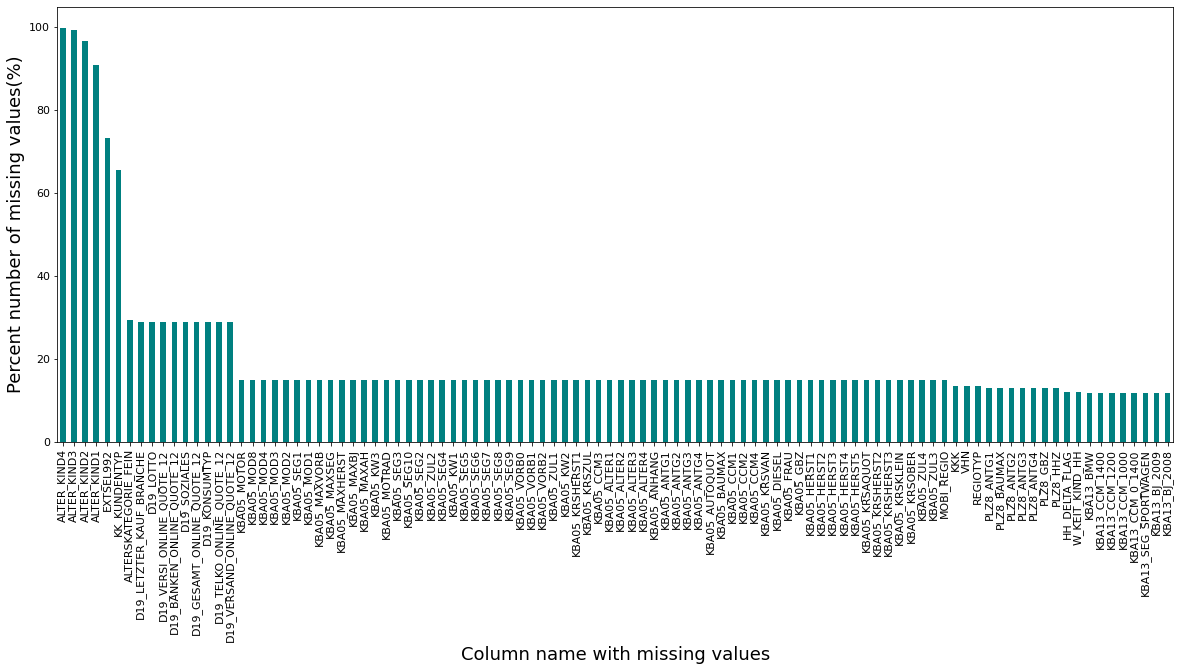

In [17]:
# Visualizing the top 50 features with naturally missing data in the original azdias dataset.
plot_top100_feat(azdias)

In [18]:
unknowns_df.head(2)

,Description,Value,Meaning,Type
Attribute,,,,
AGER_TYP,best-ager typology,-1,unknown,Categorical
ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Ordinal


In [25]:
#Changing the value entry in feat info dataframe to get a list of unknown values in every column

feat_info_dict = unknowns_df[['Value']].to_dict()['Value']

new_dict = {}
for key, value in feat_info_dict.items():
    new_dict.update({key:[str(value)]})
    
unknowns_df['new_vals'] = unknowns_df.index.map(new_dict.get)

unknowns_df['nan_vals'] = unknowns_df['new_vals'].astype(str).str.replace('[',''). \
                                             str.replace(']','').str.replace("'",'').str.split(',').values


#Converting (list of string) values to (list of integers and string) in nan_vals column.

def is_int(value):
    try:
        int(value)

        return True
    except ValueError:
       
        return False
    
unknowns_df['nan_vals'] = unknowns_df.apply(lambda x: [int(i) if is_int(i) else i for i in x['nan_vals']], axis=1)

In [20]:
unknowns_df.head(3)

,Description,Value,Meaning,Type,new_vals,nan_vals
Attribute,,,,,,
AGER_TYP,best-ager typology,-1,unknown,Categorical,[-1],[-1]
ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Ordinal,"[-1, 0]","[-1, 0]"
ALTER_HH,main age within the household,0,unknown / no main age detectable,Ordinal,[0],[0]


In [21]:
# Identify missing or unknown data values in azdias dataframe columns and convert them to NaNs as per nan_vals in feat_info
for idx in unknowns_df.index:
    column = idx
    if column in azdias.columns:
        azdias[column] = azdias[column].replace(unknowns_df.loc[column]['Value'], np.nan)

##### Adderessing the missing data in every column

The first step will be to asses how much data is missing in each column

In [22]:
# Perform an assessment of how much missing data there is in each column of the azdias dataset after encoding missing values
# Count value of NaN values in each column in descenindg order.
azdias_after_fill_nan = find_missing_vals(azdias)
azdias_after_fill_nan

,count_missing,percent
ALTER_KIND4,890016,99.86
ALTER_KIND3,885051,99.31
D19_TELKO_ONLINE_DATUM,883018,99.08
D19_BANKEN_OFFLINE_DATUM,871535,97.79
ALTER_KIND2,861722,96.69
...,...,...
CJT_TYP_4,4854,0.54
CJT_TYP_5,4854,0.54
CJT_TYP_6,4854,0.54
RETOURTYP_BK_S,4854,0.54


After mapping the unknowns from the features info df to the azdias dataframe, the real number of nulls can be seen in the dataframe

In [4]:
# Define function to plot histogram of missing data in columns
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    
    plt.figure(figsize=(20,8))
    plt.hist(df['percent'], bins=20, facecolor='teal', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()

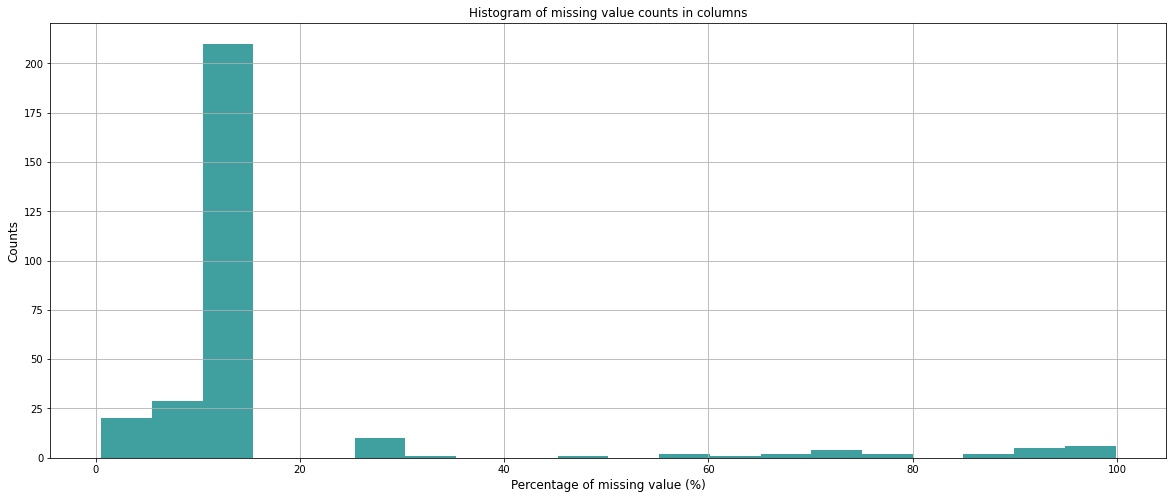

In [24]:
# Plot distribution of missing value counts in columns
plot_hist_missing_col(azdias_after_fill_nan)

As shown above, columns with more than 15% missing values are outliers in the histogram above. I will drop the columns because anything more than 15% if too significant to use any data replacement method because it would affect the distribution of the values in the specific column

In [5]:
# Define function to find columns with 15% missing values
def find_cols_missing_pct_data(df, pct):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        missing_pct_cols: (list), list of columns with more than pct missing values
    '''
    missing_pct_cols = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) * 100 > pct]
    return missing_pct_cols

In [26]:
# Find the name of columns with more than 15% missing values
missing_15 = find_cols_missing_pct_data(azdias, pct=15)
print(missing_15)

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']


In [27]:
len(missing_15)

36

In [28]:
# Remove the outlier columns from the dataset
azdias.drop(missing_15, axis=1, inplace=True)

In [29]:
# Droping column LNR from azdias dataframe as column LNR is unique ID assigned to an each individual
azdias.drop('LNR', axis=1, inplace=True)

In [30]:
azdias.shape

(891221, 329)

Discussion:

As the histograms above show, columns with more than 15% missing values seem to be the outliers. Additionally, it wouldn't be wise to impute values in columns with more than 15% missing values because the missing values are significant enough to affect the integrity of the data. 

The columsn that have more than 15% missing values are: 

'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'.

For this reason, I chose to drop these columns as shown above.

##### Assessing missing data in each Row

In this section i will assess the rows in the data to identify the the percentage of values missing in each row.

In [31]:
# How much data is missing in each row of the dataset?
azdias_null_data_row = azdias.isnull().sum(axis=1)

# Aggregate missing row data by number of missing values per row
print('Below are the number of missing values in a row along with their frequencies')
azdias_null_data_row.value_counts().sort_index()


Below are the number of missing values in a row along with their frequencies


0      664724
1          21
2       26782
3       43027
4         249
        ...  
239     45578
240        54
243        44
244         1
246         1
Length: 122, dtype: int64

In [32]:
# Aggregate missing row data by percentage of missing values per row
missing_row = azdias_null_data_row/(len(azdias.columns)) * 100
missing_row.sort_values(inplace=True)
missing_row.value_counts().sort_index()

0.000000     664724
0.303951         21
0.607903      26782
0.911854      43027
1.215805        249
              ...  
72.644377     45578
72.948328        54
73.860182        44
74.164134         1
74.772036         1
Length: 122, dtype: int64

In [7]:
# Define function to plot histogram of missing data in rows
def plot_hist_missing_row(df, pct):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the misisng data in rows
        pct - (%), percentage of missing value. 0 means with all the missing values. Anything greater than 0 means
             with missing values equal to or greater than that value i.e. 8 means, equal to or 
             more than 8 missing values           
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    df_null_data_row = df.isnull().sum(axis=1)
    df_null_data_row_percentage = df_null_data_row/(len(df.columns)) * 100
    df_null_data_row_percentage.sort_values(inplace=True)
    
    plt.figure(figsize=(20,8))
    
    if pct == 0:
        plt.hist(df_null_data_row_percentage, bins=20, facecolor='teal', alpha=0.75)
    elif pct > 0:
        plt.hist(df_null_data_row_percentage[df_null_data_row_percentage >= pct], bins=20, facecolor='teal', alpha=0.75)
        
    plt.xlabel('Percentage of missing value (%)')
    plt.ylabel('Counts')
    plt.title('Histogram of missing value counts in rows')
    plt.grid(True)
    plt.show()

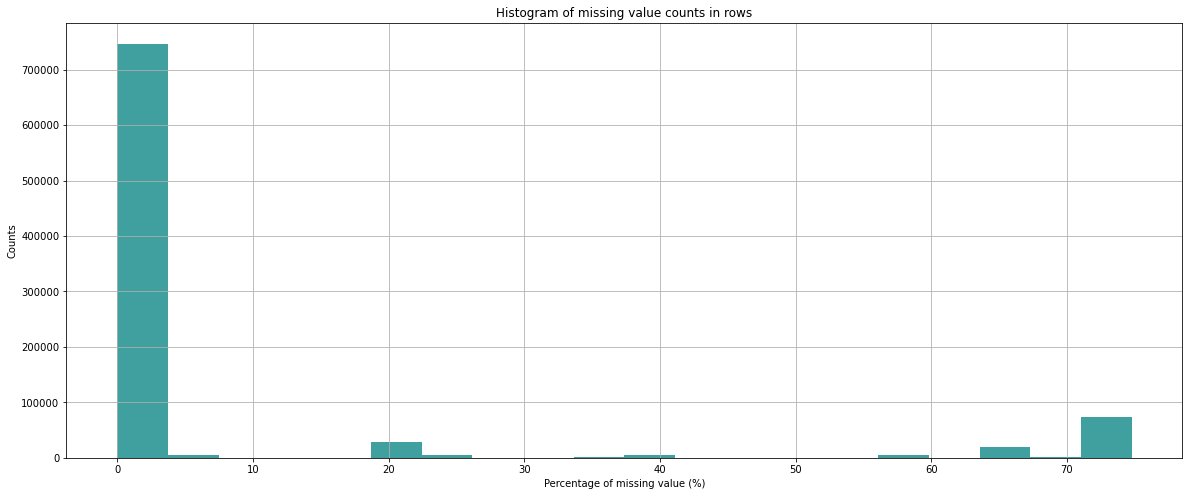

In [34]:
plot_hist_missing_row(azdias, pct = 0)

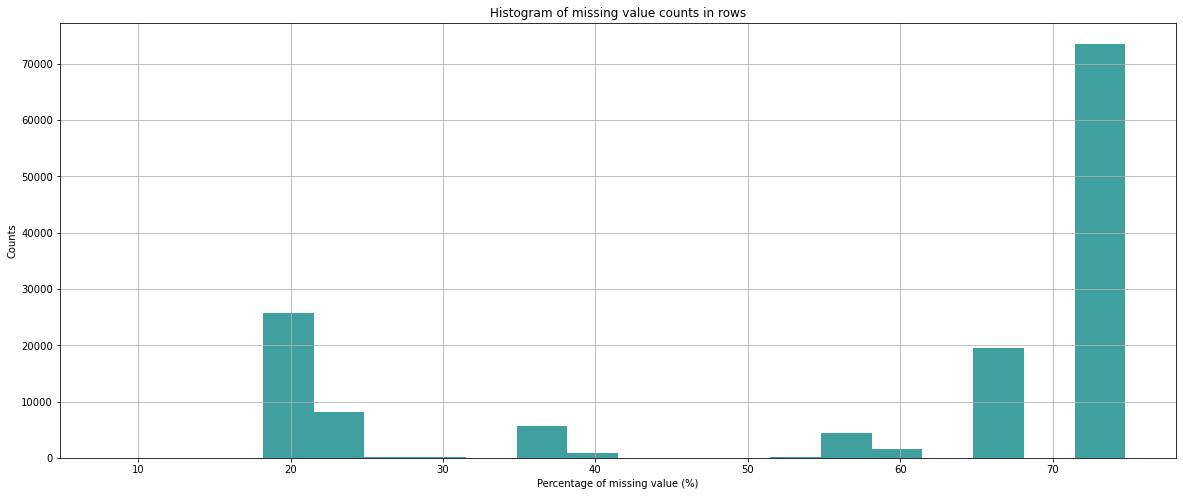

In [35]:
# Zooming in the histogram and ploting the distribution of rows with atleast 10% missing data.
plot_hist_missing_row(azdias, pct=8)

In [36]:
#Calculate cumulative sum of rows with 28 or less missing data points because 
#there is a big gap between 28 and the next number of missing values (68)
cumsum= azdias_null_data_row.value_counts().sort_index().cumsum()[:28]

cumsum_percentage = np.round(azdias_null_data_row.value_counts().sort_index().cumsum()[:28]/azdias_null_data_row.shape[0]*100,2)

In [37]:
# Calculate count and percentage of rows with no missing data points

print('Count of rows with no missing data points: {}'\
      .format(np.round(azdias_null_data_row.value_counts().sort_index().cumsum()[0])))
print('Total number of rows in the dataset : {}'.format(azdias.shape[0]))
print('Percentage of rows with no missing data points: {}%'\
      .format(np.round(azdias_null_data_row.value_counts().sort_index().cumsum()[0]/azdias.shape[0] *100,2)))

Count of rows with no missing data points: 664724
Total number of rows in the dataset : 891221
Percentage of rows with no missing data points: 74.59%


In [38]:
# Calculate percentage of rows with 8 or less missing data points

print('Count of rows with 8 or less missing data points: {}'.format(cumsum[8]))
print('Total number of rows in the dataset : {}'.format(azdias.shape[0]))
print("Percentage of rows with 8 or less missing data points:",cumsum_percentage[8],"%")

Count of rows with 8 or less missing data points: 746150
Total number of rows in the dataset : 891221
Percentage of rows with 8 or less missing data points: 83.72 %


In [39]:
# Write code to divide the data into two subsets based on the number of missing
# values to be 8 (2.5%) or less in each row.

azdias_null_data_row_few = azdias[azdias.isnull().sum(axis=1) < 8]

azdias_null_data_row_high = azdias[azdias.isnull().sum(axis=1) >= 8]

In [40]:
# Printing the number of rows with few missing data and high missing data.
print('Number of rows with few missing data : {}'.format(azdias_null_data_row_few.shape[0]))
print('Number of rows with high missing data : {}'.format(azdias_null_data_row_high.shape[0]))

# Checking if the number of rows with few missing data and high missing data adds upto total number of rows in azdias dataset.
if azdias.shape[0] == azdias_null_data_row_few.shape[0] + azdias_null_data_row_high.shape[0]:
    print('Number of rows with few missing data and high missing data adds upto total number of rows in azdias dataset,\
 which is : {}'.format(azdias_null_data_row_few.shape[0] + azdias_null_data_row_high.shape[0]))
else:
    print('Number of total rows in few missing dataset and high missing dataset is not equal\
    to the total number of rows in the dataset')

Number of rows with few missing data : 745836
Number of rows with high missing data : 145385
Number of rows with few missing data and high missing data adds upto total number of rows in azdias dataset, which is : 891221


In [41]:
# Printing columns with no or less than 2 missing values in columns of azdias dataset with outliers columns removed.

azdias_no_null_columns = azdias.isnull().sum() < 2 
print('Below are the columns of azdias dataset(outliers removed azdias dataset) with no nulls or less than 2 missing values\n')
print(azdias_no_null_columns[azdias_no_null_columns.values == True].index)

Below are the columns of azdias dataset(outliers removed azdias dataset) with no nulls or less than 2 missing values

Index(['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
       'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_REST', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT',
       'D19_WE

Randomly selected columns names with no or 1 missing values are : 
['D19_DIGIT_SERV', 'SEMIO_RAT', 'D19_TIERARTIKEL', 'D19_BANKEN_REST', 'D19_BANKEN_DIREKT', 'D19_HANDWERK', 'SEMIO_MAT']


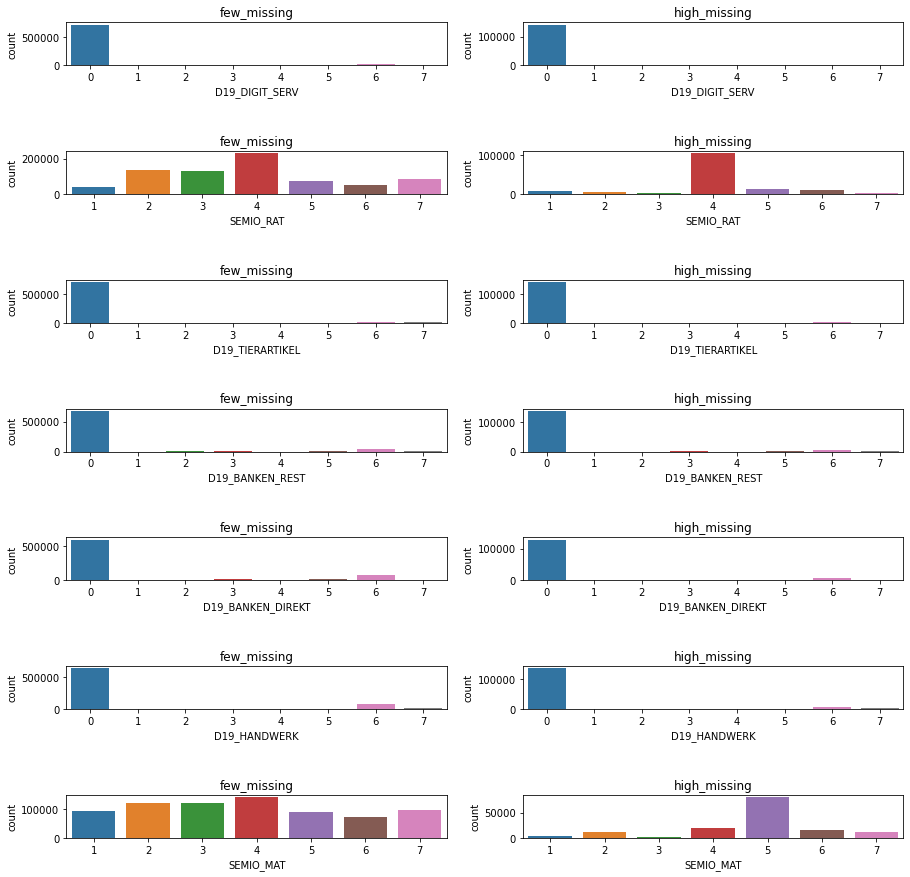

In [42]:
# Compare the distribution of values for at least 7 columns where there are
# no or few missing values, between the two subsets.

col_names_no_null = list(azdias_no_null_columns[azdias_no_null_columns.values == True].index)

# Selecting random sample from the list of columns with no null values.
random.seed(6)
random_cols = random.sample(col_names_no_null, 7)
print('Randomly selected columns names with no or 1 missing values are : \n{}'.format(random_cols))

def print_countplot(cols, num):
    
    fig, axs = plt.subplots(num,2, figsize=(15, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()

    for i in range(num):
    
        sns.countplot(azdias_null_data_row_few[cols[i]], ax=axs[i*2])
        axs[i*2].set_title('few_missing')
        
        sns.countplot(azdias_null_data_row_high[cols[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('high_missing')
    
    
print_countplot(random_cols, 7)

In [43]:
# Drop rows with high missing values in the azdias dataset.
print('Total number of rows : {}'.format(azdias.shape[0]))

azdias = azdias[azdias.index.isin(azdias_null_data_row_few.index)]

print('Number of rows after dropping rows with more than 8 missing values : {}'.format(azdias.shape[0]))

Total number of rows : 891221
Number of rows after dropping rows with more than 8 missing values : 745836


In [44]:
len(azdias.columns)

329

Discussion:

After assessing the data missing on a rwo perspective, I have removed rows missing more than 8(2.5%) values. as a result, the final dataframe has 745,836 (83.6%) values. I think retaining 83% of the original dataframe isa good start. 

From the above statistics and histograms, 74.59% of the data comprises rows with no missing values.Therefore, about three quarters of our dataset is complete. Also, we can see that there appears to be multiple groups in small patches with more than 10% of the missing data in rows making them as outliers. With 8 or less missing data in rows, we still have 83.72% of data retained. With more than 8 missing data in rows, there is not substantial increase in cumulative percentage of data retained.

Now, 2.5% of 329 columns or features turns out be in 8. We can observe that after 8 missing values in a row, there is not a substantial increase in cumulative percentage of data retained. Therefore, finding a break at 8 missing values in a row could be the appropriate choice if we have to keep rows with few missing values and droping the rows with more than 8 missing values would not lead to major issue. So, droping rows which contains more than 8 missing values in a row leads to reduction of 145,386 number of rows and our total number of rows after reduction would make our azdias dataset with 745,836 number of rows and it contains rows with maximum 8 missing values in a row.

If we compare the distribution of 7 random selected features or columns that are missing less than 2 data values in these 2 subsets(One with 8 or less missing values & other with more than 8 missing values) as can be seen from the above bar charts, we could see that the distribution of columns data within subset of few missing values is qualitatively different from the columns data within subset of many missing values. We can see features 'D19_VERSAND_DATUM', 'D19_SCHUHE', 'D19_FREIZEIT' seems comparable and other features namely 'FINANZ_ANLEGER', 'SEMIO_REL' are highly different in distribution.

Considering that the clustering algorithm K-means requires no missing information to work and that the dataset is made up of mainly ordinal and categorical data, where imputing values with means, modes or medians can impact the truth of the dataset much more than if the dataset was made up of numerical data. Therefore, it seems more appropriate to minimize imputing missing data and maintain the integrity at maximum. For this reason, I decided to retain only columns with 2.5% or less missing values. 

##### Checking columsn that do not appear in the feature description file

In [45]:
# Number of columns in azdias
len(azdias.columns)

329

In [46]:
# Find columns whcich are not in feat_info but in azdias
# Find number of attributes which are in azdias but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.index), assume_unique=True)
print(len(attr_not_in_feat_info))

81


From the above, after removing 39 outliers columns and column 'LNR' in azdias, we have reduced features from 366 to 326 in azdias. Now, we have 245 common features in azdias & feat_info i.e. 245 features had a description in feat_info. Therefore, we have 81 features in azdias which are not in feat_info i.e. 81 features in azdias didn't had a description in feat_info.

In [47]:
# Print features not in feat_info but in azdias
attr_not_in_feat_info

array(['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT',
       'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
       'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_REST', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSICHERUNGEN',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_F

I will look more into these columns to see which can be dropped

In [48]:
# Find percentage of missing values in 81 features not in feat_info
np.round(azdias[attr_not_in_feat_info.tolist()].isnull().sum().sort_values(ascending=False)/\
         azdias[attr_not_in_feat_info.tolist()].shape[0],2)

HH_DELTA_FLAG        0.04
VHN                  0.01
GEMEINDETYP          0.00
VERDICHTUNGSRAUM     0.00
STRUKTURTYP          0.00
                     ... 
D19_VOLLSORTIMENT    0.00
D19_WEIN_FEINKOST    0.00
DSL_FLAG             0.00
EINGEFUEGT_AM        0.00
AKT_DAT_KL           0.00
Length: 81, dtype: float64

In [49]:
# Print dtype of each of the 81 features not in feat_info
data_type_81 = {}
for col in attr_not_in_feat_info:
        data_type = azdias[col].dtype
        if data_type not in data_type_81:
            data_type_81[data_type] = 1
        else:
            data_type_81[data_type] += 1
    
print('Nunber of features of each data type are : {}'.format(data_type_81))

Nunber of features of each data type are : {dtype('float64'): 41, dtype('O'): 2, dtype('int64'): 38}


In [50]:
# Find col_names for each dtype in 81 features not in feat_info
int_col_name_81 = []
float_col_name_81 = []
object_col_name_81 = []

for col in attr_not_in_feat_info:
        data_type = azdias[col].dtype
        if data_type.name == 'float64':
            float_col_name_81.append(col) 
        elif data_type.name == 'int64':
            int_col_name_81.append(col)
        elif data_type == 'O':
            object_col_name_81.append(col)
            
print("Columns with float dtype: {}\n".format(float_col_name_81))
print("Columns with int dtype: {}\n".format(int_col_name_81))
print("Columns with object dtype: {}".format(object_col_name_81))

Columns with float dtype: ['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'DSL_FLAG', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']

Columns with int dtype: ['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUM

Based on the aobove analysis, the following are the findings:

-79 columns are either floast or int dtype
-2 columns namely 'CAMEO_INTL_2015', 'EINGEFUEGT_AM' are strings

The description of these columns do not appear in the features description file meaning that we do not know more about them. 

However, there are features in this category related to columns that are described in the features dataset. For example, by their sheer names,  'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6' seem to be related to CJT_GESAMTTYP due to similarity of the first 3 letters. For this reason, the information in these columns missing in the feeature information dataset could be already incorporated in the related column. There are many other features in the feratures info dataset related to a column that is in azdias dataset. 

There are also features that we do not have knowledge of whatsoever. These features could have Nan values which we do not know how they are coded due to lack of information. For this reason, keeping these records could lead to incorrect analysis. It would be better to keep records that we have information about.

For the above reason and the fact that the columns could be too many to stress the memory usage and computing resources, removing these columns could be the best possible solution.

In [51]:
# Dropping 81 features which didn't had any description in feat_info
azdias.drop(attr_not_in_feat_info.tolist(), axis=1, inplace=True)
azdias.shape

(745836, 248)

In [52]:
# Find number of attributes which are in azdias but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.index), assume_unique=True)
print(len(attr_not_in_feat_info))

0


Discussion:

In a perfect world, I would have loved to keep as much attributes as possible. However, some of the columns do not have the relevant descriptions, specifically, 81 attributes. Additionally, these features might have Nan values encoded as other values just like other features for which we have exact decription in feature summary file. We don't have what values are encoded as Nan value, so keeping those features could lead to incorrect analysis. Its better to keep features which are correctly coded for Nan values to provide better result rather than going with features which might have Nan values encoded as some other values which we are unaware about and this could lead to incorrect analysis. Since, few of the information is already present in other features and to avoid unreliability of our analysis, we had dropped them to save computing time, memory and make our analysis to be more realiable.

Additionally, if we had the necessary computing resources, I would have tried to keep all columns in the dataset.  But this is a large dataset which would really require huge computing time and memory.  Therefore, moving forward by dropping these 81 features. After dropping these 81 columns, we have now 248 columns in azdias dataframe and for each column we have description and details in feature summary file. Therefore, moving forward with 248 columns and each observation in the dataframe have missing values ranging from 0 to 8.

##### Select and Rencode Features

In this part, i will make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. For numeric and interval data, these features can be kept without changes.
Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).

Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.
In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

In [53]:
# Identify features are there of each data type in azdias dataframe
d={}
for col in azdias.columns:
    if col in feat_info.index:
        data_type = feat_info.loc[col].Type
        if data_type not in d:
            d[data_type] = 1
        else:
            d[data_type] += 1
    
print('Number of features of each data type are : {}'.format(d))

Number of features of each data type are : {'Numeric': 5, 'Ordinal': 182, 'Categorical': 55, 'Date': 2, 'Binary': 4}


###### Renecoding categorical Features

In [54]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#extract categorical columns with their data types and number of categories
binary_cat = []
multi_cat = []
date_cat = []
numeric_cat = []
ordinal_cat = []
for col in azdias.columns:
    if col in feat_info.index:
        if feat_info.loc[col].Type == 'Binary':
            binary_cat.append(col)
        elif feat_info.loc[col].Type == 'Categorical':
            multi_cat.append(col)
        elif feat_info.loc[col].Type == 'Date':
            date_cat.append(col)
        elif feat_info.loc[col].Type == 'Numeric':
            numeric_cat.append(col)
        elif feat_info.loc[col].Type == 'Ordinal':
            ordinal_cat.append(col)

In [55]:
# Printing out binary categorical values
for col in binary_cat:
    print(azdias[col].value_counts())

0    581885
1    163951
Name: GREEN_AVANTGARDE, dtype: int64
W    587159
O    158677
Name: OST_WEST_KZ, dtype: int64
2.0    376444
1.0    335140
Name: VERS_TYP, dtype: int64
2    389214
1    356622
Name: ANREDE_KZ, dtype: int64


In [56]:
binary_cat

['GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP', 'ANREDE_KZ']

In the Dataset, there are 4 binary features namely: 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP', 'ANREDE_KZ'. All of them but OST_WEST_KZ have numerical features, meaning that we will just need to convert this convert to numerical.

In [57]:
# Change 'OST_WEST_KZ' into numerical values
azdias['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)

In [58]:
azdias['OST_WEST_KZ'].value_counts()

1    587159
0    158677
Name: OST_WEST_KZ, dtype: int64

In [59]:
# Printing out binary categorical values after feature 'OST_WEST_KZ' has been re-encoded to numerical values
for col in binary_cat:
    print(azdias[col].value_counts())

0    581885
1    163951
Name: GREEN_AVANTGARDE, dtype: int64
1    587159
0    158677
Name: OST_WEST_KZ, dtype: int64
2.0    376444
1.0    335140
Name: VERS_TYP, dtype: int64
2    389214
1    356622
Name: ANREDE_KZ, dtype: int64


In [60]:
azdias.shape

(745836, 248)

##### Multicat features

In [61]:
# OneHotEncoding multi-level categoricals (three or more values), using multiple dummy variables via OneHotEncoder.
azdias = pd.get_dummies(azdias, columns=multi_cat, drop_first=True, prefix=multi_cat, dummy_na=True)

In [62]:
azdias.shape

(745836, 640)

#####  Date Related Attributes

In this section, I will look into the two date related columns namely: 'GEBURTSJAHR'(year of birth) and 'MIN_GEBAEUDEJAHR' (The first year a building was recorded in the database).

In [63]:
date_cat

['GEBURTSJAHR', 'MIN_GEBAEUDEJAHR']

In [64]:
azdias[azdias['GEBURTSJAHR']==0].shape[0]/azdias.shape[0]

0.3944781426479816

After looking into 'GEBURTSJAHR', 39% of the values have 0, implying that there is no date of birth available for 39% of the records. I prefer to drop the column because the percentage is above the 15% minimum threshold i have used to drop previous columns

In [65]:
#drop 'GEBURTSJAHR' column
azdias = azdias.drop('GEBURTSJAHR', axis = 1)
azdias.shape

(745836, 639)

In [66]:
#Loooking into the next date related column
azdias['MIN_GEBAEUDEJAHR'].value_counts(dropna=False)

1992.0    558516
1994.0     74918
1993.0     25025
1995.0     24563
1996.0     15816
1997.0     12416
1991.0      5711
2000.0      5070
1990.0      4338
2001.0      3702
1998.0      3001
1999.0      2937
2002.0      2284
1989.0      2017
2003.0      1839
2004.0      1349
1988.0      1010
2005.0       646
1987.0       453
1986.0       124
1985.0       101
Name: MIN_GEBAEUDEJAHR, dtype: int64

To simplify things, I will separate the column into two. the 90s and the 2000s

In [67]:
#Convert to string
azdias['MIN_GEBAEUDEJAHR'] = azdias['MIN_GEBAEUDEJAHR'].astype(str)

In [68]:
def make_decades(col):
    if col.startswith('1') == True:
        return 0
    else:
        return 1
azdias['MIN_GEBAEUDEJAHR'] = azdias['MIN_GEBAEUDEJAHR'].apply(make_decades)

In [69]:
azdias.shape

(745836, 639)

In [8]:
# Define function to find dtype of features in a dataset along with number of coulmns assigned to each dtype
def find_feat_dtype(df):
    """
    Find dtype of each feature in a dataframe along with number of coulmns assigned to each dtype
    
    INPUT:
        df - (dataframe), check for dtype pf features in this datafram            
    OUTPUT:
        d - (dict), dict containing dtypes along with number of features assigned to that dtype
    """
    
    d={}
    for val in df.dtypes.values:
        if val not in d:
            d[val] = 1
        else:
            d[val] += 1
            
    return d

In [71]:
# Find dtype of each feature in a dataframe along with number of coulmns assigned to each dtype
print('Nunber of features of each data type are : {}'.format(find_feat_dtype(azdias)))

Nunber of features of each data type are : {dtype('float64'): 183, dtype('int64'): 9, dtype('uint8'): 447}


Discussion:

In this stage of reencoding features, the first thing I did to ensure smooth reencoding was to manulllay add a column by the name Type to the DIAS Attributes - Values 2017 dataset that contains the information about the features. The data type had not been provided. after that, my final dataset had the following characteristics:

'Numeric': 5, 

'Ordinal': 182, 

'Categorical': 55, 

'Date': 2, 

'Binary': 4

In the Dataset, there were 4 binary features namely: 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP', 'ANREDE_KZ'. All of them but OST_WEST_KZ have numerical features, meaning that we will just needed to convert this convert to numerical.

In the multi category features, I decided to get the dummies, droped one of the dummy columsn to avoid the dummy variable trap, and also decided to include the nulls as a dummy variable.

Regarding the date related variables, after looking into 'GEBURTSJAHR', 39% of the values have 0, implying that there is no date of birth available for 39% of the records. I prefer to drop the column because the percentage is above the 15% minimum threshold i have used to drop previous columns

##### Dealing with remaining nulls in the Columns

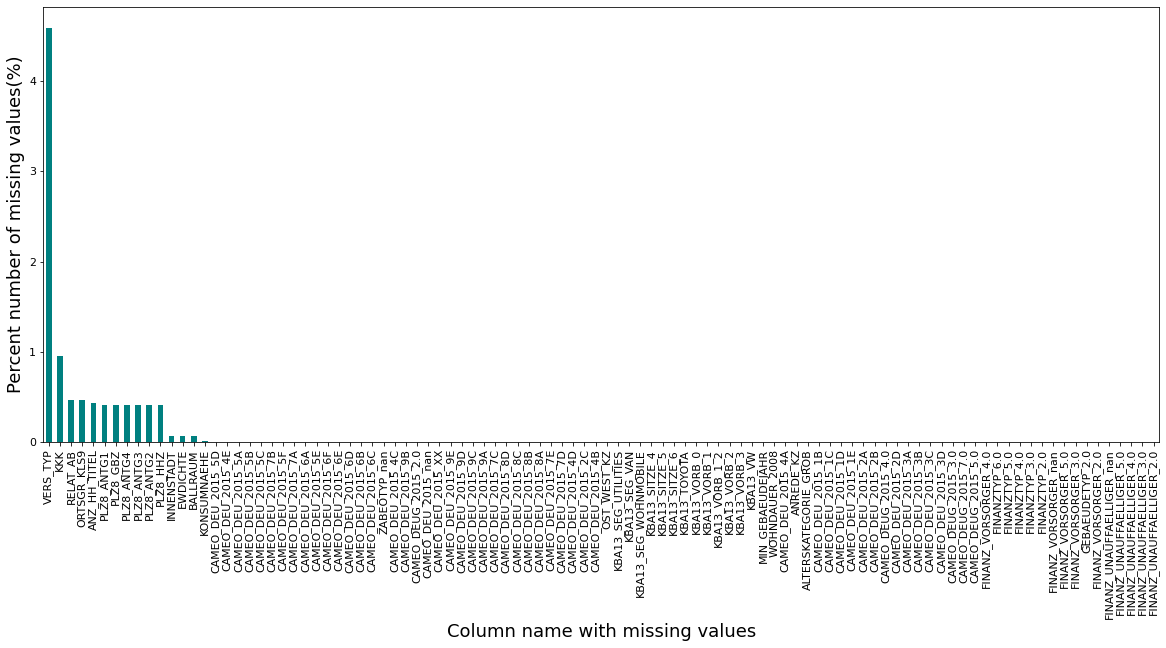

In [72]:
# Visualizing the top 50 features with naturally missing data in the original azdias dataset.
plot_top100_feat(azdias)

In [73]:
#Get the list of columns with null variables
null_cols = azdias.columns[azdias.isna().any()].tolist()
len(null_cols)

15

In [74]:
#All these columns should be in the ordinal category
# binary_cat = []
# multi_cat = []
# date_cat = []
# numeric_cat = []
# ordinal_cat = []
u = numeric_cat +  ordinal_cat + binary_cat
all(elem in u  for elem in null_cols)

True

In [75]:
#Fill the remaining null variables:
#all the above nulls, I will fill them with the mode
for col in null_cols:
    azdias[col] = azdias[col].fillna(azdias[col].mode()[0])

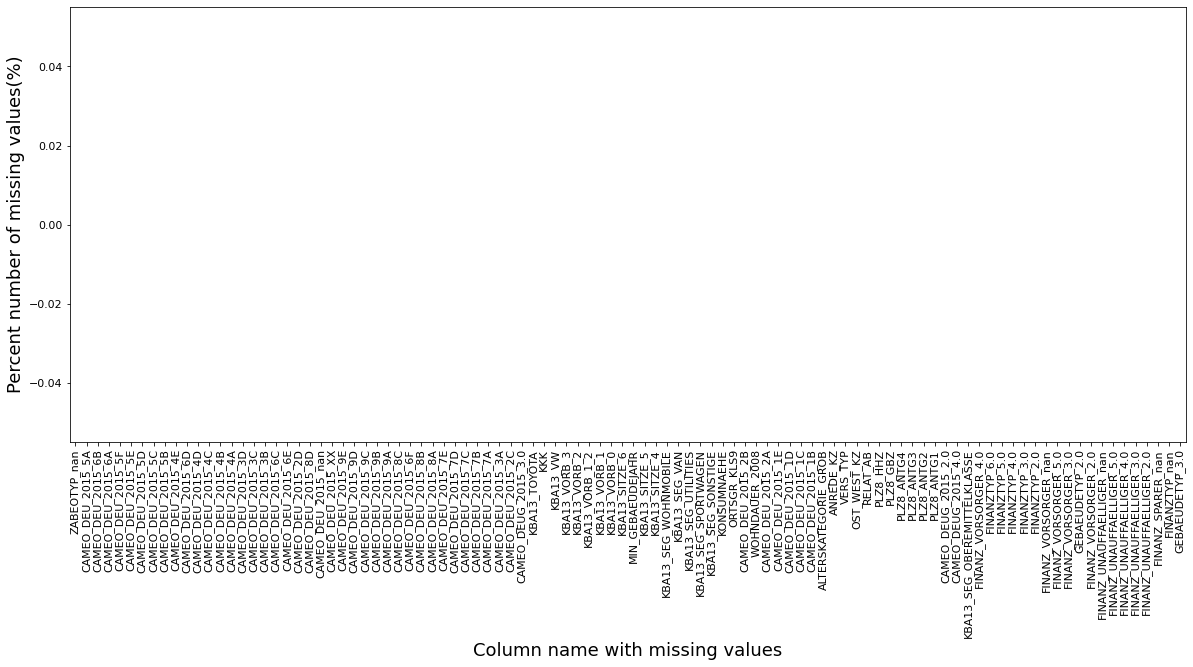

In [76]:
# Visualizing the top 50 features with naturally missing data in the original azdias dataset.
plot_top100_feat(azdias)

In [77]:
azdias.shape

(745836, 639)

In [64]:
customers_cleaned.shape

(132008, 637)

Discussion:

For imputation, we had chosen to use the mode value rather than the mean or median to fill in the missing values. Since most of the columns are categorical or ordinal in nature, mean and median could have given us values other than permissible values of which the columns comprises. The mean and median would have squashed the dataset distibutions towards a center which has no relevance with categorical and ordinal distributions. The mode seemed the logical choice as it would reinforce the highest value for each feature making them stand out more in the later analysis for customer segments.

#### Creating the cleaning function

In [4]:
def clean_data(df):
    
    print('Loading and Modifying the Feature Summary File... \n')
    # Load feature summary csv file
    # feature summary file is created manually mapping all the attributes with
    # the file has the azdias information namely: Attribute, Description, Meaning, and tYPE
    feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', 0, index_col=0)
    #Fill nulls by forward fill
    feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
    feat_info['Type'] = feat_info['Type'].fillna(method='ffill')
    #Drop duplicates
    feat_info = feat_info.drop_duplicates(subset = ['Attribute'])
    feat_info.set_index('Attribute', drop = True, inplace=True)
    
    
    print('Getting the list of Unknown Values from the Features Dataset... \n')
    #Definitions of unknowns in the various features
    list_unknown = ['unknown', 'unknown / no main age detectable', 
                'no transactions known', 'no transaction known']
    #Create a subset that has unknowns and their values
    unknowns_df = feat_info[feat_info['Meaning'].isin(list_unknown)]
    #Changing the value entry in feat info dataframe to get a list of unknown values in every column
    feat_info_dict = unknowns_df[['Value']].to_dict()['Value']
    new_dict = {}
    for key, value in feat_info_dict.items():
        new_dict.update({key:[str(value)]})
    unknowns_df['new_vals'] = unknowns_df.index.map(new_dict.get)
    unknowns_df['nan_vals'] = unknowns_df['new_vals'].astype(str).str.replace('[',''). \
                                                 str.replace(']','').str.replace("'",'').str.split(',').values
    #Converting (list of string) values to (list of integers and string) in nan_vals column.
    def is_int(value):
        try:
            int(value)

            return True
        except ValueError:

            return False
    unknowns_df['nan_vals'] = unknowns_df.apply(lambda x: [int(i) if is_int(i) else i for i in x['nan_vals']], 
                                                axis=1)
    
    print('Converting Unknowns to NaNs... \n')
    # Identify missing or unknown data values in azdias dataframe columns and convert them to NaNs as per nan_vals in feat_info
    for idx in unknowns_df.index:
        column = idx
        if column in df.columns:
            df[column] = df[column].replace(unknowns_df.loc[column]['Value'], np.nan)
            
    
    print('Removing Columns with more than 15% missing values and LNR col... \n')
    missing_15 = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
                   'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 
                   'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 
                   'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 
                   'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 
                   'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 
                   'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 
                   'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 
                   'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
    # Remove the outlier columns from the dataset
    df.drop(missing_15, axis=1, inplace=True)
    # Droping column LNR from azdias dataframe as column LNR is unique ID assigned to an each individual
    df.drop('LNR', axis=1, inplace=True)
    
    print('Identify Columns that have more than 8(2.5%) missing values... \n')
    # Drop rows with high missing values in the azdias dataset.
    df = df[df.isnull().sum(axis=1) < 8].reset_index(drop=True)
    
    
    print('Dropping Columns not in the feature Summary File... \n')
    # Find columns whcich are not in feat_info but in azdias
    # Find number of attributes which are in azdias but not in feat_info
    attr_not_in_feat_info = ['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT',
                             'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
                           'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
                           'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
                           'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
                           'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
                           'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
                           'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
                           'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
                           'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
                           'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
                           'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
                           'D19_VERSAND_REST', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
                           'D19_VERSI_ONLINE_DATUM', 'D19_VERSICHERUNGEN',
                           'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_FLAG',
                           'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE',
                           'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2',
                           'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX',
                           'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210',
                           'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ',
                           'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP',
                           'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG',
                           'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ',
                           'VK_ZG11']
    # Dropping features which didn't had any description in feat_info
    df.drop(attr_not_in_feat_info, axis=1, inplace=True)
    
    print('Reencoding Features... \n')
    # Change 'OST_WEST_KZ' into numerical values
    df['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True) 
    
    #Get categorical variables
    multi_cat = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER',
                 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
                 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_BAUMAX',
                 'KBA05_HERSTTEMP', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB',
                 'KBA05_MODTEMP', 'KBA13_MOTOR', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
                 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MOBI_REGIO', 'NATIONALITAET_KZ',
                 'ONLINE_AFFINITAET', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'RETOURTYP_BK_S',
                 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
                 'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT',
                 'SHOPPER_TYP', 'TITEL_KZ', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP']
    # OneHotEncoding multi-level categoricals (three or more values), using multiple dummy variables via OneHotEncoder.
    df = pd.get_dummies(df, columns=multi_cat, drop_first=True, prefix=multi_cat, dummy_na=True)
    #drop 'GEBURTSJAHR' column
    df = df.drop('GEBURTSJAHR', axis = 1)
    #Convert year column to decade
    df['MIN_GEBAEUDEJAHR'] = df['MIN_GEBAEUDEJAHR'].astype(str)
    def make_decades(col):
        if col.startswith('1') == True:
            return 0
        else:
            return 1
    df['MIN_GEBAEUDEJAHR'] = df['MIN_GEBAEUDEJAHR'].apply(make_decades)
    
    print('Filling the remaining nulls... \n')
    #Get the list of columns with null variables
    null_cols = df.columns[df.isna().any()].tolist()
    #Fill the remaining null variables:
    #all the above nulls, I will fill them with the mode
    for col in null_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
    print('--------Done------')
    return df

In [5]:
#Clean the azdias dataset
azdias_clean = clean_data(azdias_to_clean_func)

Loading and Modifying the Feature Summary File... 

Getting the list of Unknown Values from the Features Dataset... 

Converting Unknowns to NaNs... 

Removing Columns with more than 15% missing values and LNR col... 

Identify Columns that have more than 8(2.5%) missing values... 

Dropping Columns not in the feature Summary File... 

Reencoding Features... 

Filling the remaining nulls... 

--------Done------


In [19]:
azdias_clean.shape

(745836, 639)

In [20]:
azdias_clean.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_DATUM,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,EWDICHTE,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,MIN_GEBAEUDEJAHR,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,VERS_TYP,WOHNDAUER_2008,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CAMEO_DEU_2015_nan,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEUG_2015_nan,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3

In [6]:
#Clean the customers dataset
# Clean Customers subset file.
customers_cleaned = clean_data(customers)

Loading and Modifying the Feature Summary File... 

Getting the list of Unknown Values from the Features Dataset... 

Converting Unknowns to NaNs... 

Removing Columns with more than 15% missing values and LNR col... 

Identify Columns that have more than 8(2.5%) missing values... 

Dropping Columns not in the feature Summary File... 

Reencoding Features... 

Filling the remaining nulls... 

--------Done------


In [7]:
#Ensure the datasets have similar columns
list_tot_cols = list(set(azdias_clean.columns.tolist()) & set(customers_cleaned.columns.tolist()))
len(list_tot_cols)

637

In [8]:
#Retain similar cols
azdias_clean = azdias_clean[list_tot_cols]
customers_cleaned = customers_cleaned[list_tot_cols]

### Feature Transformation

#### Feature scaling

In this section, I will perform feature scaling before applying dimensionality reduction techniques to ensure that the principal component vectors are not influenced by the natural differences in scale features.

In [9]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_clean_scaled = scaler.fit_transform(azdias_clean)

# Making azdias_sample_scaled into a dataframe
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns= list(azdias_clean.columns.values))

azdias_clean_scaled.head(3)

,FINANZ_ANLEGER_5.0,KBA05_MAXVORB_2.0,KBA13_KMH_251,KBA05_HERSTTEMP_nan,FINANZ_SPARER_2.0,FINANZ_MINIMALIST_3.0,KBA05_HERSTTEMP_3.0,PRAEGENDE_JUGENDJAHRE_10.0,WOHNLAGE_5.0,KBA05_MAXHERST_4.0,PLZ8_BAUMAX_5.0,KBA13_SITZE_4,SEMIO_KRIT_3.0,KBA05_SEG5,KBA13_VORB_2,HH_EINKOMMEN_SCORE,MOBI_REGIO_2.0,LP_LEBENSPHASE_FEIN_34.0,LP_FAMILIE_GROB_5.0,REGIOTYP_7.0,SEMIO_SOZ_4.0,LP_FAMILIE_GROB_nan,CAMEO_DEU_2015_XX,LP_LEBENSPHASE_FEIN_31.0,CAMEO_DEUG_2015_9.0,KBA05_MOTRAD,KBA13_CCM_1600,KBA13_HERST_BMW_BENZ,KBA05_SEG8,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE_6.0,SEMIO_KRIT_6.0,FINANZ_MINIMALIST_4.0,SEMIO_MAT_5.0,GFK_URLAUBERTYP_5.0,FINANZ_HAUSBAUER_2.0,CAMEO_DEU_2015_9C,KBA13_KW_70,CAMEO_DEUG_2015_2,KBA13_CCM_1000,CAMEO_DEU_2015_1C,PRAEGENDE_JUGENDJAHRE_13.0,KBA13_CCM_0_1400,KBA13_KRSHERST_FORD_OPEL,KBA05_MAXAH_3.0,FINANZ_SPARER_4.0,LP_LEBENSPHASE_FEIN_4.0,LP_FAMILIE_FEIN_nan,KBA13_HALTER_60,KBA05_ALTER2,SEMIO_REL_5.0,KBA05_MOTOR,PRAEGENDE_JUGENDJAHRE_9.0,LP_FAMILIE_FEIN_8.0,SEMIO_MAT_3.0,LP_STATUS_GROB_3.0,CAMEO_DEU_2015_5D,SEMIO_SOZ_nan,KBA05_BAUMAX_3.0,KBA13_KRSSEG_VAN,SEMIO_PFLICHT_7.0,REGIOTYP_2.0,KBA05_HERSTTEMP_9.0,KBA05_ALTER1,RETOURTYP_BK_S_2.0,LP_LEBENSPHASE_FEIN_7.0,CAMEO_DEU_2015_7D,TITEL_KZ_3.0,FINANZ_VORSORGER_nan,SEMIO_KRIT_nan,SHOPPER_TYP_nan,KBA05_VORB1,SEMIO_LUST_4.0,SEMIO_VERT_6.0,SEMIO_SOZ_5.0,SEMIO_MAT_6.0,GFK_URLAUBERTYP_8.0,LP_LEBENSPHASE_GROB_4.0,KBA13_CCM_3001,LP_LEBENSPHASE_GROB_1.0,FINANZTYP_5.0,KBA13_KW_40,SEMIO_REL_2.0,LP_FAMILIE_FEIN_9.0,KBA05_ALTER4,REGIOTYP_nan,KBA13_VORB_3,KBA13_KW_60,GEBAEUDETYP_3.0,FINANZ_ANLEGER_nan,SEMIO_DOM_2.0,SEMIO_REL_4.0,KBA05_ZUL2,D19_GESAMT_ONLINE_DATUM,SEMIO_KAEM_6.0,KBA05_HERSTTEMP_5.0,KBA05_MODTEMP_5.0,KBA13_CCM_2501,CAMEO_DEUG_2015_5,FINANZ_UNAUFFAELLIGER_2.0,KBA05_KRSAQUOT,SEMIO_ERL_4.0,FINANZ_HAUSBAUER_5.0,SEMIO_SOZ_3.0,TITEL_KZ_5.0,LP_FAMILIE_FEIN_2.0,SEMIO_LUST_6.0,KBA13_KW_30,PRAEGENDE_JUGENDJAHRE_12.0,SEMIO_LUST_3.0,KBA05_BAUMAX_4.0,KBA05_MAXBJ_3.0,GFK_URLAUBERTYP_12.0,LP_STATUS_GROB_4.0,KBA13_VORB_0,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_ALTERHALTER_60,KBA13_HALTER_20,CAMEO_DEUG_2015_4,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_38.0,SEMIO_PFLICHT_4.0,GFK_URLAUBERTYP_4.0,LP_FAMILIE_FEIN_11.0,ANZ_HH_TITEL,CAMEO_DEUG_2015_X,KBA13_HALTER_25,KBA13_CCM_2500,FINANZ_HAUSBAUER_4.0,KBA13_KRSSEG_KLEIN,MOBI_REGIO_nan,CAMEO_DEUG_2015_3.0,KBA05_BAUMAX_5.0,GFK_URLAUBERTYP_nan,KBA13_HALTER_30,KBA13_KW_0_60,SEMIO_LUST_5.0,ONLINE_AFFINITAET_2.0,LP_LEBENSPHASE_FEIN_nan,GFK_URLAUBERTYP_9.0,KBA05_KW3,ZABEOTYP_nan,LP_STATUS_FEIN_10.0,CAMEO_DEU_2015_6C,KBA05_SEG4,LP_LEBENSPHASE_FEIN_36.0,SEMIO_TRADV_4.0,KBA05_VORB2,CAMEO_DEU_2015_6E,KBA05_MAXSEG_2.0,KBA13_KMH_110,HEALTH_TYP_2.0,KBA05_ZUL4,PLZ8_GBZ,WOHNLAGE_7.0,CJT_GESAMTTYP_5.0,ONLINE_AFFINITAET_5.0,LP_STATUS_FEIN_3.0,KBA13_HERST_SONST,LP_FAMILIE_FEIN_5.0,KBA05_MAXHERST_5.0,CAMEO_DEU_2015_5E,SEMIO_RAT_4.0,KBA13_SEG_SONSTIGE,LP_LEBENSPHASE_FEIN_26.0,ZABEOTYP_3.0,KBA13_HALTER_55,GEBAEUDETYP_8.0,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_1E,GEBAEUDETYP_RASTER_5.0,KBA13_SEG_KOMPAKTKLASSE,KBA13_KMH_140_210,KBA05_MODTEMP_6.0,BALLRAUM,GEBAEUDETYP_6.0,SHOPPER_TYP_2.0,FINANZTYP_3.0,KBA13_KW_121,SEMIO_VERT_4.0,CAMEO_DEUG_2015_9,FINANZTYP_2.0,TITEL_KZ_1.0,CJT_GESAMTTYP_3.0,ORTSGR_KLS9,SEMIO_ERL_nan,SEMIO_FAM_3.0,SEMIO_KAEM_nan,LP_LEBENSPHASE_GROB_2.0,ONLINE_AFFINITAET_3.0,SEMIO_ERL_2.0,KBA13_BJ_1999,FINANZ_MINIMALIST_2.0,LP_FAMILIE_FEIN_3.0,ONLINE_AFFINITAET_nan,KBA05_MODTEMP_3.0,SEMIO_RAT_2.0,KBA13_KRSHERST_BMW_BENZ,KBA13_SEG_OBERKLASSE,SEMIO_VERT_3.0,KBA13_MOTOR_4.0,SEMIO_ERL_3.0,SEMIO_KULT_2.0,SEMIO_MAT_4.0,NATIONALITAET_KZ_1.0,CAMEO_DEU_2015_9A,KBA05_MAXAH_2.0,KBA05_SEG7,KBA05_MAXVORB_9.0,GFK_URLAUBERTYP_10.0,KBA13_FAB_SONSTIGE,KBA05_KRSOBER,GFK_URLAUBERTYP_3.0,KBA13_BJ_2006,CAMEO_DEU_2015_3C,WOHNDAUER_2008,CAMEO_DEU_2015_1B,SEMIO_DOM_nan,CAMEO_DEU_2015_8C,LP_LEBENSPHASE_GROB_nan,KBA13_KMH_0_140,KBA05_CCM3,KBA05_HERST4,KBA05_SEG9,KBA13_SEG_UTILITIES,WOHNLAGE_2.0,KBA13_ALTERHALTER_30,FINANZ_ANLEGER_2.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_35.0,KBA13_SEG_GEL

Discussion:

The features were standardized using StandardScaler to achieve a mean of 0 and standard deviation of 1.

#### Dimensionality Reduction

With the data scaled, we are now ready to apply dimensionality reduction techniques.
Sklearn's PCA class will be used to perform principal component analysis on the data, thus finding the vectors of maximal varaiance in the data. Both the ratio of variance explained by each component as well as the cumulative variance explained will be plotted. I will then re-evaluate the number of components to keep and then re-fit the transform the data.

In [10]:
# apply PCA
pca = PCA()

# fit transform
azdias_pca = pca.fit_transform(azdias_clean_scaled)

In [11]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_

cumsum_variance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

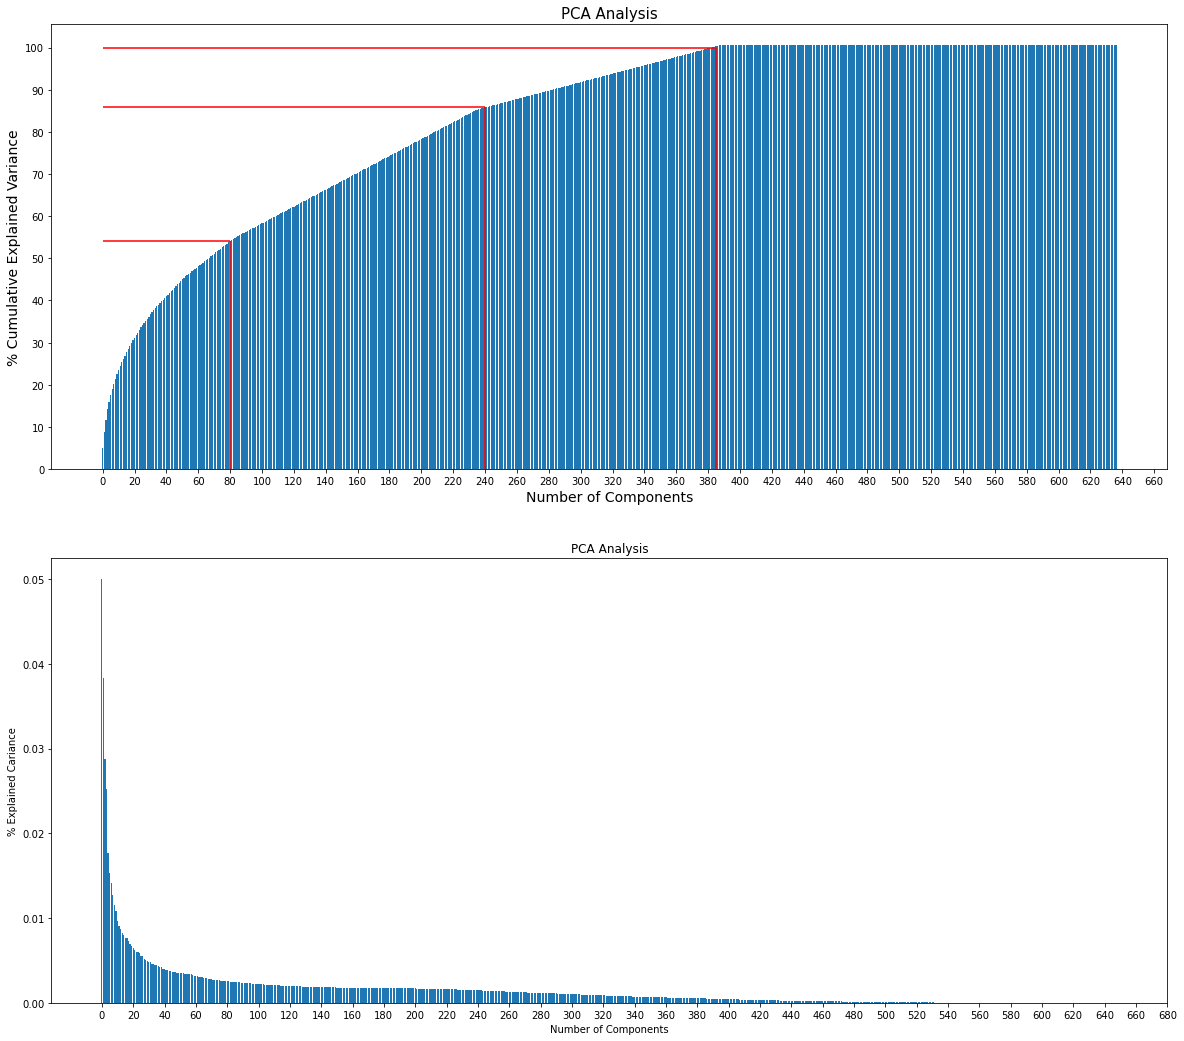

In [12]:
n_components = len(pca.explained_variance_ratio_)
index = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(20,18))
plt.subplot(2, 1, 1)
plt.bar(index, cumsum_variance)
plt.ylabel('% Cumulative Explained Variance', fontsize = 14)
plt.xlabel('Number of Components', fontsize = 14)
plt.xticks(np.linspace(0,700, 35, endpoint=False))
plt.yticks(np.linspace(0,110, 11, endpoint=False))
plt.title('PCA Analysis', fontsize = 15)

# # 80 components
plt.hlines(y=54, xmin=0, xmax=80, color='red', linestyles='-',zorder=1)
plt.vlines(x=80, ymin=0, ymax=54, color='red', linestyles='-',zorder=2)

# # 240 components
plt.hlines(y=86, xmin=0, xmax=240, color='red', linestyles='-',zorder=3)
plt.vlines(x=240, ymin=0, ymax=86, color='red', linestyles='-',zorder=4)

# # 385
plt.hlines(y=100, xmin=0, xmax=385, color='red', linestyles='-',zorder=5)
plt.vlines(x=385, ymin=0, ymax=100, color='red', linestyles='-',zorder=6)

plt.subplot(2, 1, 2)
plt.bar(index, vals)
plt.xticks(np.linspace(0,700, 35, endpoint=False))

plt.xlabel('Number of Components')
plt.ylabel('% Explained Cariance')
plt.title('PCA Analysis');

The plots above show that the explained variance plateaus twice. The first and sharpest drop-off is around 80 components. At 80 components around 54 % of the total variance is explained. After this we can observe two other, drop-offs around 237 and 385 components. At 237 components 83 % of the total variance is explained and at 385 99 % is explained.

To ensure the generalization of the model, I will settle with 237 components

In [13]:
# Getting cumulative sum of explained variance ratio.
vals = pca.explained_variance_ratio_
cumvals = list(np.cumsum(vals))
for cmv in enumerate(cumvals):
    print(cmv)

(0, 0.049989514113649484)
(1, 0.08837773103180828)
(2, 0.1171622581212188)
(3, 0.14235571303943229)
(4, 0.16007701330498064)
(5, 0.17539911782543577)
(6, 0.18957367649809356)
(7, 0.20223756039979685)
(8, 0.21380169146367856)
(9, 0.22460439515258052)
(10, 0.23428506938978308)
(11, 0.24334888366253368)
(12, 0.25202771924172374)
(13, 0.26024301649416287)
(14, 0.26827355535206293)
(15, 0.2759424668024447)
(16, 0.2835653769236996)
(17, 0.29086814817200546)
(18, 0.29780304225161736)
(19, 0.3044990483376619)
(20, 0.31098924058567373)
(21, 0.31723488706204805)
(22, 0.3232868951262172)
(23, 0.3292277120716113)
(24, 0.33507121568592874)
(25, 0.34058432105845327)
(26, 0.346053095795628)
(27, 0.3512495064664281)
(28, 0.3563377087250286)
(29, 0.3612433454369733)
(30, 0.36606948211424745)
(31, 0.3708324350719933)
(32, 0.37544233791393317)
(33, 0.3800117059708641)
(34, 0.3844605722881287)
(35, 0.38889870527948694)
(36, 0.39319668949758163)
(37, 0.3974306026591197)
(38, 0.40163031791006565)
(39, 0.405

In [14]:
n_components = 240
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

240 has a cumulative explained variane of: 0.830306605122312


In [15]:
# re-fit with n components
# apply PCA
pca_240 = PCA(n_components=n_components, random_state=SEED)

# fit transform
azdias_pca_240 = pca_240.fit_transform(azdias_clean_scaled)

Discussion:

After transforming the principle components, now we can check the weight of the each variable on the first few components to see if interpretation is possible. 

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

#### Interpreting the components

In [34]:
# The amount of variance explained by each of the selected component in pca.
pca_240.explained_variance_

array([29.49385287, 22.64907835, 16.98289375, 14.86415833, 10.45558117,
        9.04005378,  8.36300082,  7.47170151,  6.82284643,  6.37360369,
        5.71160541,  5.34765748,  5.12051969,  4.84703146,  4.73802389,
        4.52466328,  4.49752237,  4.3086399 ,  4.09159179,  3.95064701,
        3.82921601,  3.68493358,  3.57068641,  3.50508299,  3.44766461,
        3.25272987,  3.22657144,  3.06587527,  3.00202924,  2.89431124,
        2.84740336,  2.81012938,  2.71982735,  2.69589793,  2.62479826,
        2.6184698 ,  2.53577129,  2.49796747,  2.47778994,  2.37008703,
        2.33936545,  2.29114674,  2.2566414 ,  2.22602331,  2.2089265 ,
        2.15926276,  2.13661964,  2.11664481,  2.10862778,  2.09695415,
        2.09202834,  2.07252831,  2.04942835,  2.01632193,  2.00733228,
        2.00237416,  1.99380408,  1.97794795,  1.95261007,  1.8989936 ,
        1.86424383,  1.8555629 ,  1.81811268,  1.79449628,  1.7758423 ,
        1.7475447 ,  1.7255482 ,  1.70044749,  1.685705  ,  1.66

In [35]:
# Percentage of variance explained by each of the selected components in pca.
pca_240.explained_variance_ratio_

array([0.04998951, 0.03838822, 0.02878453, 0.02519345, 0.0177213 ,
       0.0153221 , 0.01417456, 0.01266388, 0.01156413, 0.0108027 ,
       0.00968067, 0.00906381, 0.00867884, 0.0082153 , 0.00803054,
       0.00766891, 0.00762291, 0.00730277, 0.00693489, 0.006696  ,
       0.00649019, 0.00624564, 0.006052  , 0.00594081, 0.00584349,
       0.00551309, 0.00546876, 0.00519639, 0.00508818, 0.00490561,
       0.0048261 , 0.00476292, 0.00460987, 0.00456931, 0.0044488 ,
       0.00443808, 0.00429791, 0.00423384, 0.00419964, 0.00401709,
       0.00396502, 0.00388329, 0.00382481, 0.00377292, 0.00374394,
       0.00365976, 0.00362138, 0.00358753, 0.00357394, 0.00355415,
       0.00354581, 0.00351276, 0.0034736 , 0.00341749, 0.00340225,
       0.00339385, 0.00337932, 0.00335245, 0.0033095 , 0.00321863,
       0.00315973, 0.00314502, 0.00308154, 0.00304152, 0.0030099 ,
       0.00296194, 0.00292465, 0.00288211, 0.00285712, 0.0028292 ,
       0.00280153, 0.0027394 , 0.00273303, 0.00269766, 0.00268

In [16]:
# Create a dataframe of Explained Variance ratio in pca_237.
dimensions = ['PC_{}'.format(i) for i in range(1,len(pca_240.components_)+1)]
ratios = pca_240.explained_variance_ratio_
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance Ratio'])
variance_ratios.index = dimensions

In [37]:
variance_ratios

,Explained Variance Ratio
PC_1,0.0500
PC_2,0.0384
PC_3,0.0288
PC_4,0.0252
PC_5,0.0177
...,...
PC_236,0.0014
PC_237,0.0014
PC_238,0.0014
PC_239,0.0014


In [17]:
# Create a dataframe with the weights for each principal component in pca_81.
# Map weights for the principal components to corresponding feature names.
components_weights = pd.DataFrame(np.round(pca_240.components_, 4), columns = azdias_clean_scaled.keys())
components_weights.index = dimensions

In [39]:
components_weights.head()

,KBA05_KRSKLEIN,SEMIO_FAM_4.0,FINANZ_VORSORGER_3.0,SEMIO_TRADV_4.0,LP_LEBENSPHASE_FEIN_25.0,KBA05_MAXBJ_4.0,KBA13_KRSAQUOT,LP_STATUS_GROB_nan,KBA05_KRSHERST2,SEMIO_RAT_6.0,LP_LEBENSPHASE_GROB_10.0,MOBI_REGIO_nan,SEMIO_KAEM_4.0,FINANZ_UNAUFFAELLIGER_3.0,KBA05_DIESEL,PLZ8_ANTG1,LP_LEBENSPHASE_GROB_12.0,WOHNDAUER_2008,KBA13_CCM_1200,KBA05_ZUL3,KBA13_RENAULT,KBA05_BAUMAX_3.0,SEMIO_PFLICHT_5.0,LP_LEBENSPHASE_FEIN_5.0,SEMIO_KULT_5.0,LP_STATUS_FEIN_5.0,KBA13_ALTERHALTER_60,REGIOTYP_4.0,KBA05_HERSTTEMP_9.0,CAMEO_DEU_2015_XX,LP_FAMILIE_FEIN_10.0,SEMIO_KAEM_7.0,KBA05_MOTOR,SEMIO_KRIT_nan,CAMEO_DEU_2015_5C,RETOURTYP_BK_S_2.0,KBA13_HALTER_50,KBA13_KRSSEG_OBER,KBA13_BJ_2006,KBA13_KW_80,SEMIO_RAT_4.0,SEMIO_KRIT_5.0,LP_STATUS_FEIN_6.0,LP_LEBENSPHASE_FEIN_23.0,KBA05_MAXAH_9.0,SEMIO_VERT_6.0,KBA13_ALTERHALTER_45,KBA05_MOTRAD,LP_LEBENSPHASE_GROB_11.0,GEBAEUDETYP_RASTER_2.0,KBA13_KRSHERST_AUDI_VW,LP_FAMILIE_GROB_nan,SEMIO_DOM_5.0,KBA13_HALTER_20,KBA13_KW_40,LP_LEBENSPHASE_FEIN_38.0,KBA05_MAXSEG_9.0,ONLINE_AFFINITAET_5.0,GFK_URLAUBERTYP_12.0,KBA13_BJ_2009,KBA13_KW_61_120,TITEL_KZ_1.0,SEMIO_KAEM_nan,ZABEOTYP_2.0,LP_LEBENSPHASE_GROB_4.0,LP_STATUS_GROB_5.0,PLZ8_BAUMAX_5.0,LP_FAMILIE_FEIN_1.0,SEMIO_KRIT_7.0,LP_LEBENSPHASE_FEIN_29.0,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_3C,KBA05_ZUL2,SEMIO_DOM_2.0,SEMIO_RAT_7.0,KBA05_MOD1,TITEL_KZ_5.0,KBA05_KRSOBER,LP_LEBENSPHASE_FEIN_1.0,SEMIO_VERT_5.0,REGIOTYP_2.0,CAMEO_DEU_2015_nan,KBA13_BJ_2004,GEBAEUDETYP_3.0,GFK_URLAUBERTYP_8.0,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_2C,LP_FAMILIE_FEIN_4.0,KBA05_SEG10,SEMIO_KULT_nan,KBA05_ALTER2,KBA13_SEG_SPORTWAGEN,KBA13_HERST_AUDI_VW,CAMEO_DEU_2015_1D,GFK_URLAUBERTYP_7.0,CAMEO_DEU_2015_3A,KBA05_MAXHERST_2.0,KBA13_BMW,KBA13_HALTER_65,SEMIO_ERL_7.0,INNENSTADT,PRAEGENDE_JUGENDJAHRE_14.0,ZABEOTYP_nan,SHOPPER_TYP_3.0,KBA13_MOTOR_3.0,PLZ8_BAUMAX_nan,LP_LEBENSPHASE_FEIN_32.0,GFK_URLAUBERTYP_4.0,LP_LEBENSPHASE_FEIN_34.0,FINANZ_SPARER_5.0,KBA05_ZUL4,KBA13_KRSZUL_NEU,LP_LEBENSPHASE_FEIN_14.0,KBA13_HERST_SONST,VERS_TYP,GEBAEUDETYP_nan,GFK_URLAUBERTYP_nan,FINANZ_MINIMALIST_4.0,LP_LEBENSPHASE_FEIN_10.0,KBA13_CCM_1800,LP_LEBENSPHASE_FEIN_37.0,NATIONALITAET_KZ_3.0,W_KEIT_KIND_HH_4.0,KBA13_KMH_211,KBA13_KMH_110,PRAEGENDE_JUGENDJAHRE_nan,KBA05_MAXBJ_3.0,CJT_GESAMTTYP_4.0,KBA05_HERSTTEMP_5.0,KBA05_HERSTTEMP_nan,REGIOTYP_7.0,LP_STATUS_FEIN_7.0,PLZ8_ANTG3,SEMIO_FAM_nan,KBA13_SEG_MINIVANS,SEMIO_KAEM_6.0,KBA05_KW1,CAMEO_DEU_2015_7E,KBA05_SEG3,LP_STATUS_FEIN_3.0,LP_FAMILIE_GROB_2.0,CAMEO_DEU_2015_2D,SEMIO_VERT_4.0,FINANZ_ANLEGER_3.0,SEMIO_PFLICHT_7.0,CAMEO_DEUG_2015_5.0,KBA05_VORB2,PRAEGENDE_JUGENDJAHRE_12.0,KBA05_MAXVORB_nan,SEMIO_VERT_3.0,CAMEO_DEU_2015_9A,W_KEIT_KIND_HH_1.0,KBA05_KRSHERST1,LP_STATUS_FEIN_9.0,KBA13_KW_70,KBA05_ANTG3,LP_LEBENSPHASE_FEIN_18.0,KBA05_HERST3,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MODTEMP_3.0,RETOURTYP_BK_S_5.0,KBA05_MAXVORB_3.0,KBA13_KW_60,LP_LEBENSPHASE_GROB_9.0,SEMIO_KULT_7.0,LP_LEBENSPHASE_FEIN_20.0,PLZ8_GBZ,CAMEO_DEU_2015_6B,KBA13_KW_90,KBA13_VORB_1,KBA05_ALTER1,SEMIO_PFLICHT_6.0,KBA05_MODTEMP_nan,LP_STATUS_GROB_3.0,SEMIO_MAT_2.0,ZABEOTYP_6.0,KBA13_NISSAN,CAMEO_DEU_2015_9D,KBA05_ALTER3,KBA13_CCM_1000,KBA13_KMH_140,CAMEO_DEUG_2015_1,LP_FAMILIE_FEIN_8.0,PLZ8_BAUMAX_3.0,SEMIO_VERT_2.0,REGIOTYP_1.0,SEMIO_SOZ_5.0,CAMEO_DEU_2015_6C,KBA05_BAUMAX_4.0,KBA13_MOTOR_2.0,FINANZ_VORSORGER_4.0,LP_LEBENSPHASE_FEIN_6.0,CAMEO_DEU_2015_9B,KBA05_KRSAQUOT,GEBAEUDETYP_RASTER_nan,KBA13_SEG_KLEINWAGEN,FINANZTYP_4.0,KBA13_VORB_3,LP_LEBENSPHASE_FEIN_39.0,LP_STATUS_FEIN_2.0,KBA13_HERST_BMW_BENZ,KBA05_BAUMAX_2.0,RETOURTYP_BK_S_3.0,KBA13_SEG_KLEINST,SEMIO_FAM_2.0,GEBAEUDETYP_4.0,KBA13_CCM_2500,LP_FAMILIE_GROB_5.0,SEMIO_RAT_2.0,PRAEGENDE_JUGENDJAHRE_3.0,KBA05_MOD3,KBA13_SEG_MINIWAGEN,WOHNLAGE_1.0,PRAEGENDE_JUGENDJAHRE_7.0,SEMIO_SOZ_6.0,KBA13_MERCEDES,KBA05_ANTG2,CAMEO_DEUG_2015_7.0,KBA05_CCM4,LP_FAMILIE_GROB_1.0,KBA13_KRSSEG_KLEIN,SEMIO_PFLICHT_4.0,KBA13_KMH_180,FINANZ_VORSORGER_5.0,KBA13_SEG_GELAENDEWAGEN,W_KEIT_KIND_HH_2.0,SEMIO_KRIT_2.0,KBA13_BJ_2000,KBA05_HERSTTEMP_4.0,MOBI_REGIO_2.0,GFK_URLAUBERTYP_9.0,D19

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Highest positive and negative weights for the first Principal Componnent

def weights_sorted_p_comp(n_p_comp, n_weights):
    p_comp = 'PC' + '_' + str(n_p_comp)
    print("Principal Component", (n_p_comp))
    print('-' * 30)
    print("\nTop positive weights are below\n")
    print(components_weights.loc[p_comp].sort_values(ascending=False)[:n_weights])
    print('-' * 30)
    print("\nTop negative weights are below\n")
    print(components_weights.loc[p_comp].sort_values()[:n_weights])

In [41]:
# Plot the feature weights as a function of the components
def plot_component_weights(n_p_comp, n_weights):
    '''
    n_p_comp: prinicipal component number
    n_weights: number of top positive and top negative weights
    '''
    p_comp = 'PC' + '_' + str(n_p_comp)
    comp_weight_first_last = components_weights.loc[p_comp].sort_values(ascending=False)[:n_weights].append(
                                    components_weights.loc[p_comp].sort_values()[:n_weights])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,6))
    comp_weight_first_last.plot(ax = ax, kind = 'barh')

    # Turn on the grid
    ax.grid()
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    # Customize the grid
    ax.grid(linewidth='0.5', alpha=0.5)

    #comp_weight_first_last.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(list(comp_weight_first_last.index), rotation='vertical')
    plt.show()

In [42]:
# Getting top 5 positive and negative weights of a principal component 1.
weights_sorted_p_comp(1, 5)

Principal Component 1
------------------------------

Top positive weights are below

KBA05_MAXSEG_9.0      0.1803
KBA05_MAXVORB_9.0     0.1803
KBA05_MAXHERST_9.0    0.1803
KBA05_MAXBJ_9.0       0.1803
KBA05_MAXAH_9.0       0.1803
Name: PC_1, dtype: float64
------------------------------

Top negative weights are below

KBA05_HERSTTEMP_3.0   -0.0301
KBA05_MAXVORB_3.0     -0.0268
KBA05_MAXSEG_2.0      -0.0258
KBA05_MAXHERST_3.0    -0.0193
KBA05_ANTG3           -0.0188
Name: PC_1, dtype: float64


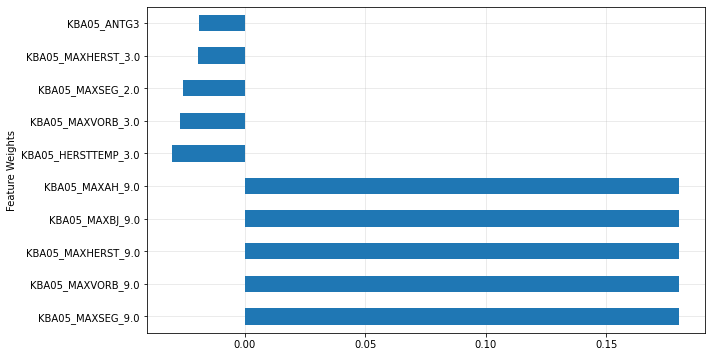

In [43]:
# Plotting the top 5 positive and negative weights of a principal component 1.
plot_component_weights(1, 5)

In [44]:
# Getting top 5 positive and negative weights of a principal component 2.
weights_sorted_p_comp(2, 5)

Principal Component 2
------------------------------

Top positive weights are below

HH_EINKOMMEN_SCORE    0.1520
PLZ8_ANTG3            0.1514
PLZ8_ANTG4            0.1455
ORTSGR_KLS9           0.1170
EWDICHTE              0.1167
Name: PC_2, dtype: float64
------------------------------

Top negative weights are below

PLZ8_ANTG1        -0.1548
KBA05_ANTG1       -0.1539
KBA05_GBZ         -0.1425
KBA13_AUTOQUOTE   -0.1357
PLZ8_GBZ          -0.1203
Name: PC_2, dtype: float64


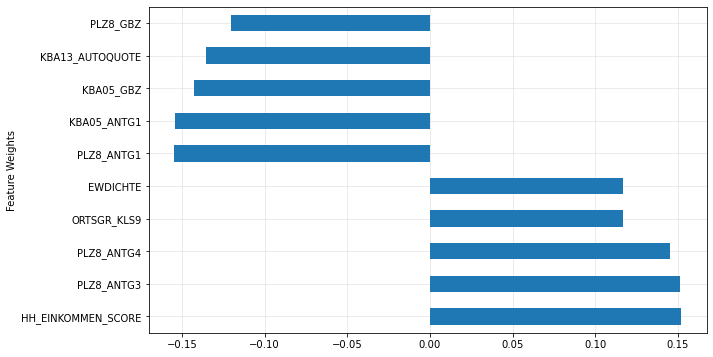

In [45]:
# Plotting the top 5 positive and negative weights of a principal component 2.
plot_component_weights(2, 5)

In [46]:
# Getting top 5 positive and negative weights of a principal component 2.
weights_sorted_p_comp(3, 5)

Principal Component 3
------------------------------

Top positive weights are below

KBA13_HERST_BMW_BENZ           0.1838
KBA13_SEG_OBEREMITTELKLASSE    0.1588
KBA13_MERCEDES                 0.1559
KBA13_BMW                      0.1549
KBA13_SITZE_4                  0.1504
Name: PC_3, dtype: float64
------------------------------

Top negative weights are below

KBA13_SITZE_5          -0.1498
KBA13_KMH_140_210      -0.1332
KBA13_SEG_KLEINWAGEN   -0.1266
KBA13_HALTER_20        -0.1261
KBA13_ALTERHALTER_60   -0.1215
Name: PC_3, dtype: float64


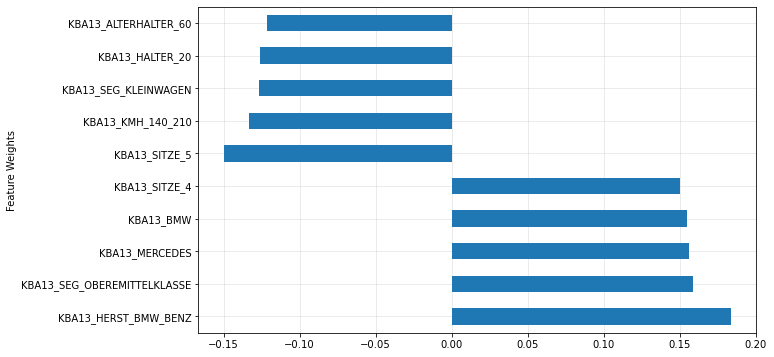

In [45]:
# Plotting the top 5 positive and negative weights of a principal component 2.
plot_component_weights(3, 5)

In [46]:
# Getting top 5 positive and negative weights of a principal component 2.
weights_sorted_p_comp(4, 5)

Principal Component 4
------------------------------

Top positive weights are below

PRAEGENDE_JUGENDJAHRE_14.0    0.1514
SEMIO_TRADV_5.0               0.1434
SEMIO_KULT_7.0                0.1434
SEMIO_SOZ_7.0                 0.1434
SEMIO_FAM_7.0                 0.1428
Name: PC_4, dtype: float64
------------------------------

Top negative weights are below

ALTERSKATEGORIE_GROB      -0.2001
ZABEOTYP_3.0              -0.1556
FINANZ_VORSORGER_5.0      -0.1523
RETOURTYP_BK_S_5.0        -0.1402
LP_LEBENSPHASE_GROB_2.0   -0.1181
Name: PC_4, dtype: float64


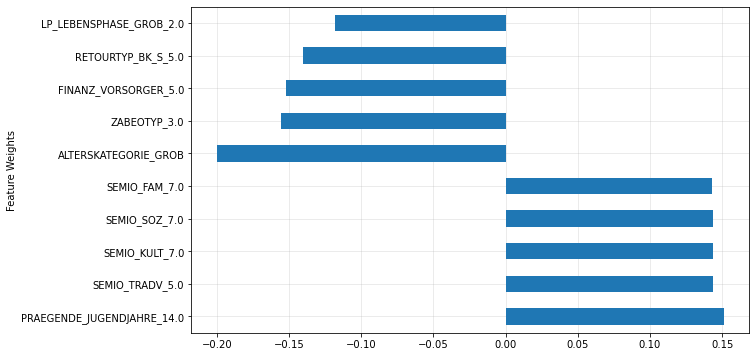

In [47]:
# Plotting the top 5 positive and negative weights of a principal component 2.
plot_component_weights(4, 5)

In [48]:
# Getting top 5 positive and negative weights of a principal component 2.
weights_sorted_p_comp(5, 5)

Principal Component 5
------------------------------

Top positive weights are below

SEMIO_ERL_4.0      0.1919
SEMIO_KAEM_3.0     0.1882
SEMIO_REL_4.0      0.1668
SEMIO_KRIT_5.0     0.1666
SEMIO_TRADV_4.0    0.1593
Name: PC_5, dtype: float64
------------------------------

Top negative weights are below

ANREDE_KZ         -0.2811
SEMIO_VERT_2.0    -0.1692
SEMIO_TRADV_3.0   -0.1502
SEMIO_ERL_6.0     -0.1445
SEMIO_DOM_7.0     -0.1436
Name: PC_5, dtype: float64


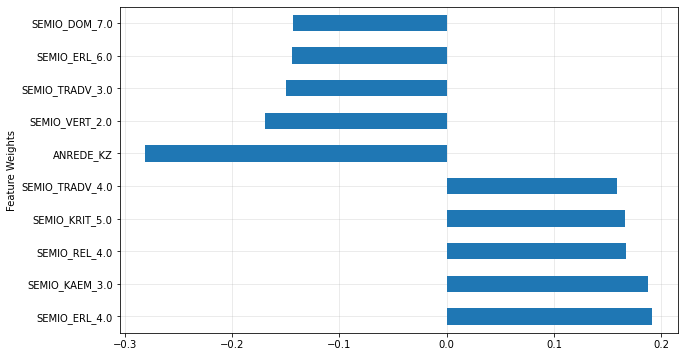

In [49]:
# Plotting the top 5 positive and negative weights of a principal component 2.
plot_component_weights(5, 5)

In [20]:
feat_info['Attribute'] = feat_info.index

In [48]:
def plot_feature_weights(df, pca, feat_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in feat_info.Attribute.values:
            feat_descs.append(feat_info[feat_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.barh(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

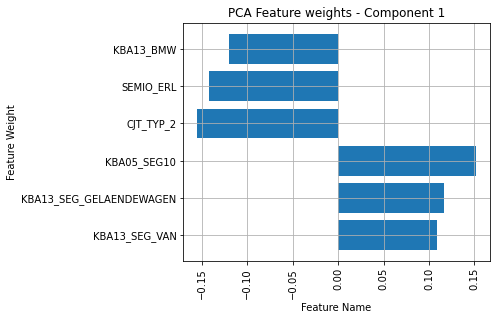

,Feature,Description,FeatureWeight
0,KBA05_SEG10,"share of more specific cars (Vans, convertables, all-terrains, MUVs etc.)",0.151372
1,KBA13_SEG_GELAENDEWAGEN,share of allterrain within the PLZ8,0.116748
2,KBA13_SEG_VAN,share of vans within the PLZ8,0.108767
3,KBA13_BMW,share of BMW within the PLZ8,-0.120254
4,SEMIO_ERL,affinity indicating in what way the person is eventful orientated,-0.142456
5,CJT_TYP_2,No description given,-0.154768


In [97]:
component_1_info = plot_feature_weights(azdias, pca_240, feat_info, 1, 3)
component_1_info.head(10)

Discussion:

The. first 5 components make up 16% of the total variance of the dataset. The first componenet makes up 5% of the toal variance.

Each component is a combination of the 639 features left after cleaning, with each feature given a weight relative to its importance for a particular principal component. The higher the weight either positive or negative, the more impact the feature has on the calculation of the principal component. What value of weight is important is subjective and depends on the context.

#### Clustering

After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [21]:

#Function to identify scores for each kmeans model by different centroids
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [23]:
scores, range_ = get_Kmeans_scores(azdias_pca_240, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  350514943.6834858
Time elapsed: 99.01 sec.

Training for n_clusters:  3
Done! Score:  329329388.4025437
Time elapsed: 145.11 sec.

Training for n_clusters:  4
Done! Score:  323305175.0511888
Time elapsed: 217.27 sec.

Training for n_clusters:  5
Done! Score:  318374183.4067553
Time elapsed: 216.83 sec.

Training for n_clusters:  6
Done! Score:  313815331.9903162
Time elapsed: 215.74 sec.

Training for n_clusters:  7
Done! Score:  310389318.9416094
Time elapsed: 282.90 sec.

Training for n_clusters:  8
Done! Score:  307552113.4679615
Time elapsed: 247.59 sec.

Training for n_clusters:  9
Done! Score:  305089179.1956808
Time elapsed: 381.43 sec.

Training for n_clusters:  10
Done! Score:  302890093.2486359
Time elapsed: 423.53 sec.

Training for n_clusters:  11
Done! Score:  300483881.4168939
Time elapsed: 370.57 sec.

Training for n_clusters:  12
Done! Score:  298614466.68124
Time 

In [24]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="teal")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

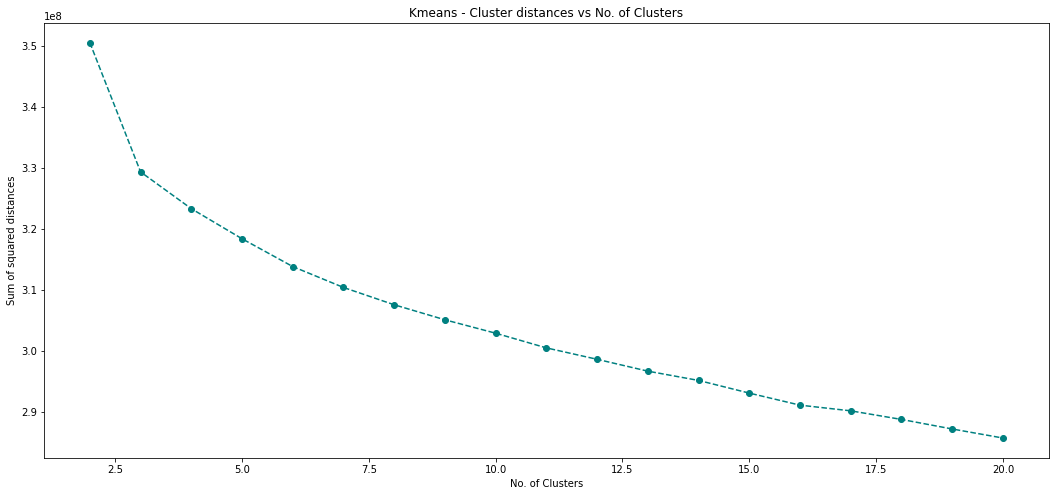

In [25]:
plot_elbow(scores, range_)

##### Choosing the number of clusters

The idea behind the elbow method, is that the number of clusters can be selected in such a way that adding one more cluster to the existing clusters will not improve the intra-cluster variation. Which means adding a cluster will not reduce the sum of sqaured distances between the clusters. 

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around 7 clusters and then the slope decreases.

In [26]:
#Fit the model specifying the 7 clusters
kmeans_7 = KMeans(7, random_state=SEED)

model_7 = kmeans_7.fit(azdias_pca_240)

In [27]:
#Make predictions
azdias_clusters_preds = model_7.predict(azdias_pca_240)

In [50]:
# Print clusters for first 10 observations in azdias_sample_pca
azdias_clusters_preds[:10]

array([5, 2, 1, 2, 5, 5, 4, 2, 2, 3], dtype=int32)

In [51]:
# Total number of unique clusters in sample general population data
np.unique(azdias_clusters_preds)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [52]:
# Distribution of general population sample data in clusters
pd.Series(azdias_clusters_preds).value_counts().sort_index()

0    103031
1    160520
2    106976
3    148060
4     97686
5    115619
6     13944
dtype: int64

#### Applying General population data to Customer Data

After fitting the data to the general population and coming up with the 7 clusters, now we can map the customer data to these clusters. 

In [53]:
customers_cleaned.head(2)

,KBA05_KRSKLEIN,SEMIO_FAM_4.0,FINANZ_VORSORGER_3.0,SEMIO_TRADV_4.0,LP_LEBENSPHASE_FEIN_25.0,KBA05_MAXBJ_4.0,KBA13_KRSAQUOT,LP_STATUS_GROB_nan,KBA05_KRSHERST2,SEMIO_RAT_6.0,LP_LEBENSPHASE_GROB_10.0,MOBI_REGIO_nan,SEMIO_KAEM_4.0,FINANZ_UNAUFFAELLIGER_3.0,KBA05_DIESEL,PLZ8_ANTG1,LP_LEBENSPHASE_GROB_12.0,WOHNDAUER_2008,KBA13_CCM_1200,KBA05_ZUL3,KBA13_RENAULT,KBA05_BAUMAX_3.0,SEMIO_PFLICHT_5.0,LP_LEBENSPHASE_FEIN_5.0,SEMIO_KULT_5.0,LP_STATUS_FEIN_5.0,KBA13_ALTERHALTER_60,REGIOTYP_4.0,KBA05_HERSTTEMP_9.0,CAMEO_DEU_2015_XX,LP_FAMILIE_FEIN_10.0,SEMIO_KAEM_7.0,KBA05_MOTOR,SEMIO_KRIT_nan,CAMEO_DEU_2015_5C,RETOURTYP_BK_S_2.0,KBA13_HALTER_50,KBA13_KRSSEG_OBER,KBA13_BJ_2006,KBA13_KW_80,SEMIO_RAT_4.0,SEMIO_KRIT_5.0,LP_STATUS_FEIN_6.0,LP_LEBENSPHASE_FEIN_23.0,KBA05_MAXAH_9.0,SEMIO_VERT_6.0,KBA13_ALTERHALTER_45,KBA05_MOTRAD,LP_LEBENSPHASE_GROB_11.0,GEBAEUDETYP_RASTER_2.0,KBA13_KRSHERST_AUDI_VW,LP_FAMILIE_GROB_nan,SEMIO_DOM_5.0,KBA13_HALTER_20,KBA13_KW_40,LP_LEBENSPHASE_FEIN_38.0,KBA05_MAXSEG_9.0,ONLINE_AFFINITAET_5.0,GFK_URLAUBERTYP_12.0,KBA13_BJ_2009,KBA13_KW_61_120,TITEL_KZ_1.0,SEMIO_KAEM_nan,ZABEOTYP_2.0,LP_LEBENSPHASE_GROB_4.0,LP_STATUS_GROB_5.0,PLZ8_BAUMAX_5.0,LP_FAMILIE_FEIN_1.0,SEMIO_KRIT_7.0,LP_LEBENSPHASE_FEIN_29.0,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_3C,KBA05_ZUL2,SEMIO_DOM_2.0,SEMIO_RAT_7.0,KBA05_MOD1,TITEL_KZ_5.0,KBA05_KRSOBER,LP_LEBENSPHASE_FEIN_1.0,SEMIO_VERT_5.0,REGIOTYP_2.0,CAMEO_DEU_2015_nan,KBA13_BJ_2004,GEBAEUDETYP_3.0,GFK_URLAUBERTYP_8.0,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_2C,LP_FAMILIE_FEIN_4.0,KBA05_SEG10,SEMIO_KULT_nan,KBA05_ALTER2,KBA13_SEG_SPORTWAGEN,KBA13_HERST_AUDI_VW,CAMEO_DEU_2015_1D,GFK_URLAUBERTYP_7.0,CAMEO_DEU_2015_3A,KBA05_MAXHERST_2.0,KBA13_BMW,KBA13_HALTER_65,SEMIO_ERL_7.0,INNENSTADT,PRAEGENDE_JUGENDJAHRE_14.0,ZABEOTYP_nan,SHOPPER_TYP_3.0,KBA13_MOTOR_3.0,PLZ8_BAUMAX_nan,LP_LEBENSPHASE_FEIN_32.0,GFK_URLAUBERTYP_4.0,LP_LEBENSPHASE_FEIN_34.0,FINANZ_SPARER_5.0,KBA05_ZUL4,KBA13_KRSZUL_NEU,LP_LEBENSPHASE_FEIN_14.0,KBA13_HERST_SONST,VERS_TYP,GEBAEUDETYP_nan,GFK_URLAUBERTYP_nan,FINANZ_MINIMALIST_4.0,LP_LEBENSPHASE_FEIN_10.0,KBA13_CCM_1800,LP_LEBENSPHASE_FEIN_37.0,NATIONALITAET_KZ_3.0,W_KEIT_KIND_HH_4.0,KBA13_KMH_211,KBA13_KMH_110,PRAEGENDE_JUGENDJAHRE_nan,KBA05_MAXBJ_3.0,CJT_GESAMTTYP_4.0,KBA05_HERSTTEMP_5.0,KBA05_HERSTTEMP_nan,REGIOTYP_7.0,LP_STATUS_FEIN_7.0,PLZ8_ANTG3,SEMIO_FAM_nan,KBA13_SEG_MINIVANS,SEMIO_KAEM_6.0,KBA05_KW1,CAMEO_DEU_2015_7E,KBA05_SEG3,LP_STATUS_FEIN_3.0,LP_FAMILIE_GROB_2.0,CAMEO_DEU_2015_2D,SEMIO_VERT_4.0,FINANZ_ANLEGER_3.0,SEMIO_PFLICHT_7.0,CAMEO_DEUG_2015_5.0,KBA05_VORB2,PRAEGENDE_JUGENDJAHRE_12.0,KBA05_MAXVORB_nan,SEMIO_VERT_3.0,CAMEO_DEU_2015_9A,W_KEIT_KIND_HH_1.0,KBA05_KRSHERST1,LP_STATUS_FEIN_9.0,KBA13_KW_70,KBA05_ANTG3,LP_LEBENSPHASE_FEIN_18.0,KBA05_HERST3,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MODTEMP_3.0,RETOURTYP_BK_S_5.0,KBA05_MAXVORB_3.0,KBA13_KW_60,LP_LEBENSPHASE_GROB_9.0,SEMIO_KULT_7.0,LP_LEBENSPHASE_FEIN_20.0,PLZ8_GBZ,CAMEO_DEU_2015_6B,KBA13_KW_90,KBA13_VORB_1,KBA05_ALTER1,SEMIO_PFLICHT_6.0,KBA05_MODTEMP_nan,LP_STATUS_GROB_3.0,SEMIO_MAT_2.0,ZABEOTYP_6.0,KBA13_NISSAN,CAMEO_DEU_2015_9D,KBA05_ALTER3,KBA13_CCM_1000,KBA13_KMH_140,CAMEO_DEUG_2015_1,LP_FAMILIE_FEIN_8.0,PLZ8_BAUMAX_3.0,SEMIO_VERT_2.0,REGIOTYP_1.0,SEMIO_SOZ_5.0,CAMEO_DEU_2015_6C,KBA05_BAUMAX_4.0,KBA13_MOTOR_2.0,FINANZ_VORSORGER_4.0,LP_LEBENSPHASE_FEIN_6.0,CAMEO_DEU_2015_9B,KBA05_KRSAQUOT,GEBAEUDETYP_RASTER_nan,KBA13_SEG_KLEINWAGEN,FINANZTYP_4.0,KBA13_VORB_3,LP_LEBENSPHASE_FEIN_39.0,LP_STATUS_FEIN_2.0,KBA13_HERST_BMW_BENZ,KBA05_BAUMAX_2.0,RETOURTYP_BK_S_3.0,KBA13_SEG_KLEINST,SEMIO_FAM_2.0,GEBAEUDETYP_4.0,KBA13_CCM_2500,LP_FAMILIE_GROB_5.0,SEMIO_RAT_2.0,PRAEGENDE_JUGENDJAHRE_3.0,KBA05_MOD3,KBA13_SEG_MINIWAGEN,WOHNLAGE_1.0,PRAEGENDE_JUGENDJAHRE_7.0,SEMIO_SOZ_6.0,KBA13_MERCEDES,KBA05_ANTG2,CAMEO_DEUG_2015_7.0,KBA05_CCM4,LP_FAMILIE_GROB_1.0,KBA13_KRSSEG_KLEIN,SEMIO_PFLICHT_4.0,KBA13_KMH_180,FINANZ_VORSORGER_5.0,KBA13_SEG_GELAENDEWAGEN,W_KEIT_KIND_HH_2.0,SEMIO_KRIT_2.0,KBA13_BJ_2000,KBA05_HERSTTEMP_4.0,MOBI_REGIO_2.0,GFK_URLAUBERTYP_9.0,D19

In [54]:
customers_cleaned.shape

(132008, 637)

In [56]:
#Check if there are any nulls
sum(customers_cleaned.isna().sum(axis = 1))

0

In [28]:
# Apply feature scaling to the customers demographics data.
# Apply scaler to transform customer dataframe

customers_scaled = scaler.transform(customers_cleaned)

# Making azdias_scaled into a dataframe
customers_scaled = pd.DataFrame(customers_scaled, columns= list(customers_cleaned.columns.values))
customers_scaled.head()

,FINANZ_ANLEGER_5.0,KBA05_MAXVORB_2.0,KBA13_KMH_251,KBA05_HERSTTEMP_nan,FINANZ_SPARER_2.0,FINANZ_MINIMALIST_3.0,KBA05_HERSTTEMP_3.0,PRAEGENDE_JUGENDJAHRE_10.0,WOHNLAGE_5.0,KBA05_MAXHERST_4.0,PLZ8_BAUMAX_5.0,KBA13_SITZE_4,SEMIO_KRIT_3.0,KBA05_SEG5,KBA13_VORB_2,HH_EINKOMMEN_SCORE,MOBI_REGIO_2.0,LP_LEBENSPHASE_FEIN_34.0,LP_FAMILIE_GROB_5.0,REGIOTYP_7.0,SEMIO_SOZ_4.0,LP_FAMILIE_GROB_nan,CAMEO_DEU_2015_XX,LP_LEBENSPHASE_FEIN_31.0,CAMEO_DEUG_2015_9.0,KBA05_MOTRAD,KBA13_CCM_1600,KBA13_HERST_BMW_BENZ,KBA05_SEG8,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE_6.0,SEMIO_KRIT_6.0,FINANZ_MINIMALIST_4.0,SEMIO_MAT_5.0,GFK_URLAUBERTYP_5.0,FINANZ_HAUSBAUER_2.0,CAMEO_DEU_2015_9C,KBA13_KW_70,CAMEO_DEUG_2015_2,KBA13_CCM_1000,CAMEO_DEU_2015_1C,PRAEGENDE_JUGENDJAHRE_13.0,KBA13_CCM_0_1400,KBA13_KRSHERST_FORD_OPEL,KBA05_MAXAH_3.0,FINANZ_SPARER_4.0,LP_LEBENSPHASE_FEIN_4.0,LP_FAMILIE_FEIN_nan,KBA13_HALTER_60,KBA05_ALTER2,SEMIO_REL_5.0,KBA05_MOTOR,PRAEGENDE_JUGENDJAHRE_9.0,LP_FAMILIE_FEIN_8.0,SEMIO_MAT_3.0,LP_STATUS_GROB_3.0,CAMEO_DEU_2015_5D,SEMIO_SOZ_nan,KBA05_BAUMAX_3.0,KBA13_KRSSEG_VAN,SEMIO_PFLICHT_7.0,REGIOTYP_2.0,KBA05_HERSTTEMP_9.0,KBA05_ALTER1,RETOURTYP_BK_S_2.0,LP_LEBENSPHASE_FEIN_7.0,CAMEO_DEU_2015_7D,TITEL_KZ_3.0,FINANZ_VORSORGER_nan,SEMIO_KRIT_nan,SHOPPER_TYP_nan,KBA05_VORB1,SEMIO_LUST_4.0,SEMIO_VERT_6.0,SEMIO_SOZ_5.0,SEMIO_MAT_6.0,GFK_URLAUBERTYP_8.0,LP_LEBENSPHASE_GROB_4.0,KBA13_CCM_3001,LP_LEBENSPHASE_GROB_1.0,FINANZTYP_5.0,KBA13_KW_40,SEMIO_REL_2.0,LP_FAMILIE_FEIN_9.0,KBA05_ALTER4,REGIOTYP_nan,KBA13_VORB_3,KBA13_KW_60,GEBAEUDETYP_3.0,FINANZ_ANLEGER_nan,SEMIO_DOM_2.0,SEMIO_REL_4.0,KBA05_ZUL2,D19_GESAMT_ONLINE_DATUM,SEMIO_KAEM_6.0,KBA05_HERSTTEMP_5.0,KBA05_MODTEMP_5.0,KBA13_CCM_2501,CAMEO_DEUG_2015_5,FINANZ_UNAUFFAELLIGER_2.0,KBA05_KRSAQUOT,SEMIO_ERL_4.0,FINANZ_HAUSBAUER_5.0,SEMIO_SOZ_3.0,TITEL_KZ_5.0,LP_FAMILIE_FEIN_2.0,SEMIO_LUST_6.0,KBA13_KW_30,PRAEGENDE_JUGENDJAHRE_12.0,SEMIO_LUST_3.0,KBA05_BAUMAX_4.0,KBA05_MAXBJ_3.0,GFK_URLAUBERTYP_12.0,LP_STATUS_GROB_4.0,KBA13_VORB_0,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_ALTERHALTER_60,KBA13_HALTER_20,CAMEO_DEUG_2015_4,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_38.0,SEMIO_PFLICHT_4.0,GFK_URLAUBERTYP_4.0,LP_FAMILIE_FEIN_11.0,ANZ_HH_TITEL,CAMEO_DEUG_2015_X,KBA13_HALTER_25,KBA13_CCM_2500,FINANZ_HAUSBAUER_4.0,KBA13_KRSSEG_KLEIN,MOBI_REGIO_nan,CAMEO_DEUG_2015_3.0,KBA05_BAUMAX_5.0,GFK_URLAUBERTYP_nan,KBA13_HALTER_30,KBA13_KW_0_60,SEMIO_LUST_5.0,ONLINE_AFFINITAET_2.0,LP_LEBENSPHASE_FEIN_nan,GFK_URLAUBERTYP_9.0,KBA05_KW3,ZABEOTYP_nan,LP_STATUS_FEIN_10.0,CAMEO_DEU_2015_6C,KBA05_SEG4,LP_LEBENSPHASE_FEIN_36.0,SEMIO_TRADV_4.0,KBA05_VORB2,CAMEO_DEU_2015_6E,KBA05_MAXSEG_2.0,KBA13_KMH_110,HEALTH_TYP_2.0,KBA05_ZUL4,PLZ8_GBZ,WOHNLAGE_7.0,CJT_GESAMTTYP_5.0,ONLINE_AFFINITAET_5.0,LP_STATUS_FEIN_3.0,KBA13_HERST_SONST,LP_FAMILIE_FEIN_5.0,KBA05_MAXHERST_5.0,CAMEO_DEU_2015_5E,SEMIO_RAT_4.0,KBA13_SEG_SONSTIGE,LP_LEBENSPHASE_FEIN_26.0,ZABEOTYP_3.0,KBA13_HALTER_55,GEBAEUDETYP_8.0,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_1E,GEBAEUDETYP_RASTER_5.0,KBA13_SEG_KOMPAKTKLASSE,KBA13_KMH_140_210,KBA05_MODTEMP_6.0,BALLRAUM,GEBAEUDETYP_6.0,SHOPPER_TYP_2.0,FINANZTYP_3.0,KBA13_KW_121,SEMIO_VERT_4.0,CAMEO_DEUG_2015_9,FINANZTYP_2.0,TITEL_KZ_1.0,CJT_GESAMTTYP_3.0,ORTSGR_KLS9,SEMIO_ERL_nan,SEMIO_FAM_3.0,SEMIO_KAEM_nan,LP_LEBENSPHASE_GROB_2.0,ONLINE_AFFINITAET_3.0,SEMIO_ERL_2.0,KBA13_BJ_1999,FINANZ_MINIMALIST_2.0,LP_FAMILIE_FEIN_3.0,ONLINE_AFFINITAET_nan,KBA05_MODTEMP_3.0,SEMIO_RAT_2.0,KBA13_KRSHERST_BMW_BENZ,KBA13_SEG_OBERKLASSE,SEMIO_VERT_3.0,KBA13_MOTOR_4.0,SEMIO_ERL_3.0,SEMIO_KULT_2.0,SEMIO_MAT_4.0,NATIONALITAET_KZ_1.0,CAMEO_DEU_2015_9A,KBA05_MAXAH_2.0,KBA05_SEG7,KBA05_MAXVORB_9.0,GFK_URLAUBERTYP_10.0,KBA13_FAB_SONSTIGE,KBA05_KRSOBER,GFK_URLAUBERTYP_3.0,KBA13_BJ_2006,CAMEO_DEU_2015_3C,WOHNDAUER_2008,CAMEO_DEU_2015_1B,SEMIO_DOM_nan,CAMEO_DEU_2015_8C,LP_LEBENSPHASE_GROB_nan,KBA13_KMH_0_140,KBA05_CCM3,KBA05_HERST4,KBA05_SEG9,KBA13_SEG_UTILITIES,WOHNLAGE_2.0,KBA13_ALTERHALTER_30,FINANZ_ANLEGER_2.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_35.0,KBA13_SEG_GEL

In [29]:
# Apply PCA to the customers_scaled data
# Apply general population Principal Component transformation on customers_scaled dataframe

customers_pca = pca_240.transform(customers_scaled)

In [59]:
# Shape of customers_pca
customers_pca.shape

(132008, 240)

In [30]:
# Apply fitted kmeans object from general population demographics onto the customer data,
# obtaining cluster predictions for the customer demographics data.

predict_customers_clusters = model_7.predict(customers_pca)

In [61]:
# Print clusters for first 10 observations in clustomers_cleaned
predict_customers_clusters[:10]

array([0, 0, 1, 3, 2, 0, 0, 2, 0, 0], dtype=int32)

In [62]:
# Total number of unique clusters in customers_cleaned data
np.unique(predict_customers_clusters)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [63]:
# Distribution of customers_cleaned data in clusters
pd.Series(predict_customers_clusters).value_counts().sort_index()

0    57720
1    33642
2    21339
3    14168
4     2571
5     1685
6      883
dtype: int64

#### Comparing Customer Data to Demographics data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this step, I will compare the two cluster distributions to see where the strongest customer base for the company is.


Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [31]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Number of data points within each general population cluster.
population_clusters = pd.Series(azdias_clusters_preds)
count_pc = population_clusters.value_counts().sort_index()
count_pc

0    126721
1    123025
2    99519 
3    13944 
4    154265
5    88584 
6    139778
dtype: int64

In [32]:
# Number of data points within each customers cluster.
customers_clusters = pd.Series(predict_customers_clusters)
count_cc = customers_clusters.value_counts().sort_index()
print(type(count_cc))
count_cc

<class 'pandas.core.series.Series'>


0    2045 
1    63516
2    2759 
3    883  
4    33438
5    8571 
6    20796
dtype: int64

In [33]:
# Create a dataframe from counts of data points within each population and customer clusters.
pop_cust_clusters_data_count_df = pd.concat([count_pc, count_cc], axis=1).reset_index()
pop_cust_clusters_data_count_df.columns = ['cluster', 'population', 'customer']
#pop_cust_clusters_data_count_df.index.name = 'cluster'
pop_cust_clusters_data_count_df

,cluster,population,customer
0,0,126721,2045
1,1,123025,63516
2,2,99519,2759
3,3,13944,883
4,4,154265,33438
5,5,88584,8571
6,6,139778,20796


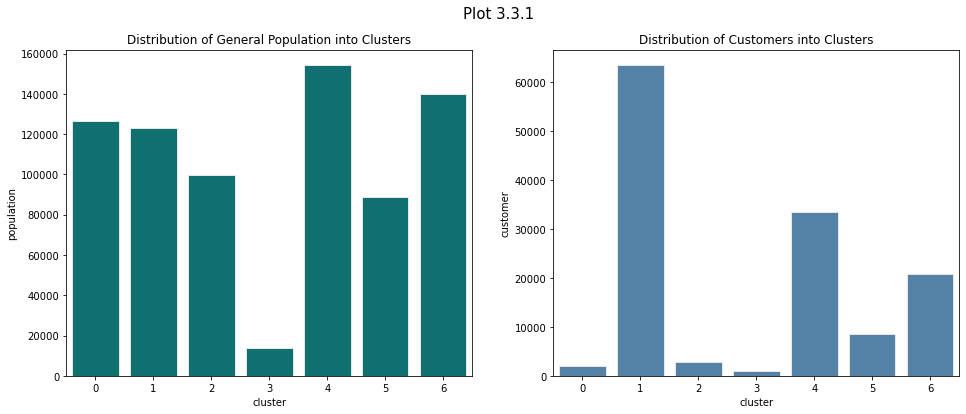

In [34]:
# Visualize absolute values dataframe as bar charts
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x=pop_cust_clusters_data_count_df['cluster'],\
                  y=pop_cust_clusters_data_count_df['population'],\
                  color='teal',edgecolor='.9')
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x=pop_cust_clusters_data_count_df['cluster'],\
                  y=pop_cust_clusters_data_count_df['customer'],\
                  color='steelblue',edgecolor='.9')

plt.title("Distribution of Customers into Clusters")
plt.suptitle("Plot 3.3.1", fontsize=15);

In [35]:
# Add ratio and ratio difference for each cluster to the dataframe
pop_cust_clusters_data_count_df['pop_%'] = (pop_cust_clusters_data_count_df['population']\
                                            /pop_cust_clusters_data_count_df['population'].sum()*100).round(2)
pop_cust_clusters_data_count_df['cust_%'] = (pop_cust_clusters_data_count_df['customer']\
                                             /pop_cust_clusters_data_count_df['customer'].sum()*100).round(2)
pop_cust_clusters_data_count_df['diff'] = pop_cust_clusters_data_count_df['cust_%'] - pop_cust_clusters_data_count_df['pop_%']
pop_cust_clusters_data_count_df

,cluster,population,customer,pop_%,cust_%,diff
0,0,126721,2045,16.99,1.55,-15.44
1,1,123025,63516,16.49,48.12,31.63
2,2,99519,2759,13.34,2.09,-11.25
3,3,13944,883,1.87,0.67,-1.20
4,4,154265,33438,20.68,25.33,4.65
5,5,88584,8571,11.88,6.49,-5.39
6,6,139778,20796,18.74,15.75,-2.99


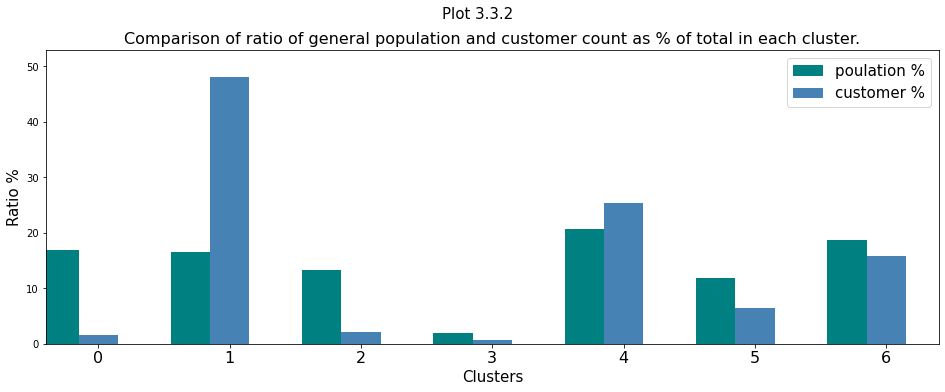

In [36]:
# Visualize ratios for each cluster

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = pop_cust_clusters_data_count_df['pop_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                   color='teal',width=-0.3, align='edge',position=0)
ax = pop_cust_clusters_data_count_df['cust_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                    color='steelblue',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels= pop_cust_clusters_data_count_df['cluster'])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer count as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot 3.3.2", fontsize=15)
plt.show()

In [38]:
# General population data with missing values in row(rows with more than 8 missing values)

# Number of rows with few missing data : 745836
# Number of rows with high missing data : 145385
# Number of rows with few missing data and high missing data adds
# upto total number of rows in azdias dataset, which is : 891221
#azdias_null_data_row_high.shape[0]

In [75]:
customers.shape[0]

191652

In [39]:
# Missing rows from customer dataset
customers_null_data_row_few = customers[customers.isnull().sum(axis=1) < 8].reset_index(drop=True)
customers_null_data_row_high = customers[customers.isnull().sum(axis=1) >= 8].reset_index(drop=True)

In [40]:
pop_cust_clusters_data_count_df.head(2)

,cluster,population,customer,pop_%,cust_%,diff
0,0,126721,2045,16.99,1.55,-15.44
1,1,123025,63516,16.49,48.12,31.63


In [41]:
# Add missing data rows as an extra cluster to pop_cust_clusters_data_count_df dataframe
pop_cust_clusters_data_count_df.loc[-1] = ['-1', 145385,\
                                           customers_null_data_row_high.shape[0],0,0,0]  # adding a row
pop_cust_clusters_data_count_df.index = pop_cust_clusters_data_count_df.index + 1  # shifting index
pop_cust_clusters_data_count_df.sort_index(inplace=True)
pop_cust_clusters_data_count_df.head(3)

,cluster,population,customer,pop_%,cust_%,diff
0,-1,145385,59644,0.00,0.00,0.00
1,0,126721,2045,16.99,1.55,-15.44
2,1,123025,63516,16.49,48.12,31.63


In [42]:
# Recalculate ratios and differences
pop_cust_clusters_data_count_df['pop_%'] = (pop_cust_clusters_data_count_df['population']\
                                            /pop_cust_clusters_data_count_df['population'].sum()*100).round(2)
pop_cust_clusters_data_count_df['cust_%'] = (pop_cust_clusters_data_count_df['customer']\
                                             /pop_cust_clusters_data_count_df['customer'].sum()*100).round(2)
pop_cust_clusters_data_count_df['diff'] = pop_cust_clusters_data_count_df['cust_%'] - pop_cust_clusters_data_count_df['pop_%']

pop_cust_clusters_data_count_df

,cluster,population,customer,pop_%,cust_%,diff
0,-1,145385,59644,16.31,31.12,14.81
1,0,126721,2045,14.22,1.07,-13.15
2,1,123025,63516,13.80,33.14,19.34
3,2,99519,2759,11.17,1.44,-9.73
4,3,13944,883,1.56,0.46,-1.10
5,4,154265,33438,17.31,17.45,0.14
6,5,88584,8571,9.94,4.47,-5.47
7,6,139778,20796,15.68,10.85,-4.83


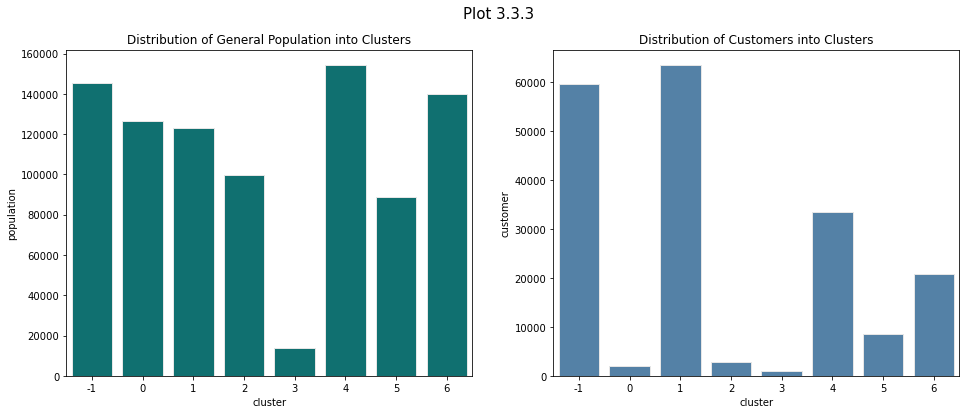

In [43]:
# Re-visualize plot with missing row data added as cluster -1
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x=pop_cust_clusters_data_count_df['cluster'],\
                  y=pop_cust_clusters_data_count_df['population'],\
                  color='teal',edgecolor='.9')
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x=pop_cust_clusters_data_count_df['cluster'],\
                  y=pop_cust_clusters_data_count_df['customer'],\
                  color='steelblue',edgecolor='.9')

plt.title("Distribution of Customers into Clusters")
plt.suptitle("Plot 3.3.3", fontsize=15);

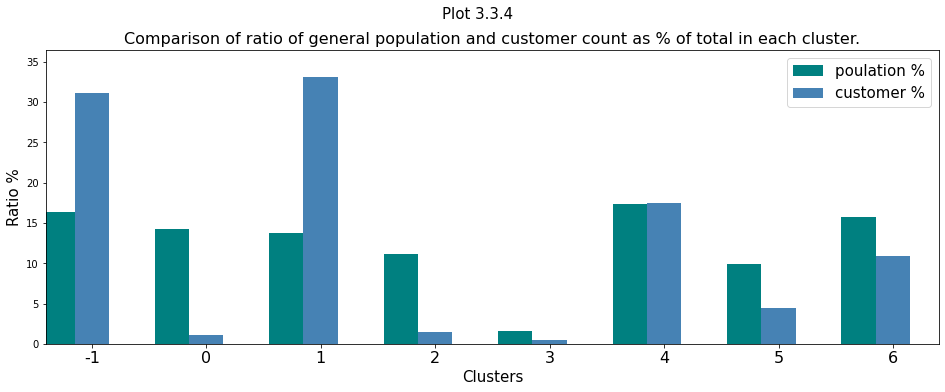

In [44]:
# Re-visualize cluster ratios with missing row cluster -1

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = pop_cust_clusters_data_count_df['pop_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                   color='teal',width=-0.3, align='edge',position=0)
ax = pop_cust_clusters_data_count_df['cust_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                    color='steelblue',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels= pop_cust_clusters_data_count_df['cluster'])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer count as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot 3.3.4", fontsize=15)
plt.show()


In [45]:
pop_cust_clusters_data_count_df

,cluster,population,customer,pop_%,cust_%,diff
0,-1,145385,59644,16.31,31.12,14.81
1,0,126721,2045,14.22,1.07,-13.15
2,1,123025,63516,13.80,33.14,19.34
3,2,99519,2759,11.17,1.44,-9.73
4,3,13944,883,1.56,0.46,-1.10
5,4,154265,33438,17.31,17.45,0.14
6,5,88584,8571,9.94,4.47,-5.47
7,6,139778,20796,15.68,10.85,-4.83


From the above visualization, we can observe that there is a proportion difference of +18.56% between customer proportion and general population proportion assigned to cluster 0. Therefore, cluster 0 over-represents customers of the company. For this reason, cluster 0 should be the top among the target customers because customers in that population are more likely to engage with the company. Other clusters that could be considered are cluster 1 and 2.


Also, we can observe that there is a proportion difference of -12.09% between customer proportion and general population proportion assigned to cluster 5. Therefore, cluster 5 under-represents customer data compared to general population.  Other clusters that are underrepresented are clusters 3 and 4 which have proprotion difference of -9.22% and -9.62% respectively. These clusters are not likely to engage the company compared to the ones that are over-represented.

##### Learnng more about the clusters

In [46]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, 
                    feat_info, num_components=2, num_feat_per_comp=3):
    
    weights = model_7.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, feat_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [49]:
cluster_0 = explain_cluster(model_7, 0, azdias, pca_240, feat_info)
cluster_0

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,1,3.351283,CJT_TYP_2,No description given,0.152050
1,1,3.351283,KBA13_HALTER_20,share of car owners below 21 within the PLZ8,0.117000
2,1,3.351283,SEMIO_DOM,affinity indicating in what way the person is dominant minded,0.116748
3,1,3.351283,KBA05_KW3,share of cars with an engine power of more than 119 KW,-0.101455
4,1,3.351283,VERDICHTUNGSRAUM,No description given,-0.118209
5,1,3.351283,KBA13_ANTG3,No description given,-0.120254
6,3,3.160440,ZABEOTYP,typification of energy consumers,0.143368
7,3,3.160440,KBA13_NISSAN,share of NISSAN within the PLZ8,0.142816
8,3,3.160440,AKT_DAT_KL,No description given,0.127284
9,3,3.160440,W_KEIT_KIND_HH,likelihood of a child present in this household,-0.152306


In [55]:
cluster_1 = explain_cluster(model_7, 1, azdias, pca_240, feat_info)
cluster_1

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,3.383074,D19_BILDUNG,No description given,0.183770
1,2,3.383074,KBA13_SEG_OBERKLASSE,share of upper class cars (BMW 7er etc.) in the PLZ8,0.154864
2,2,3.383074,CAMEO_INTL_2015,No description given,0.150401
3,2,3.383074,KBA13_SEG_MINIWAGEN,share of minicars within the PLZ8,-0.126641
4,2,3.383074,KBA13_CCM_1600,share of cars with 1500ccm to 1599ccm within the PLZ8,-0.133217
5,2,3.383074,KBA13_RENAULT,share of RENAULT within the PLZ8,-0.149775
6,6,1.672020,KBA05_KRSZUL,share of newbuilt cars (referred to the county average),0.124956
7,6,1.672020,KBA13_BAUMAX,No description given,0.110176
8,6,1.672020,KBA13_KMH_251,share of cars with a greater max speed than 250 km/h within the PLZ8,0.110176
9,6,1.672020,KBA13_HALTER_55,share of car owners between 51 and 55 within the PLZ8,-0.100008


In [58]:
cluster_2 = explain_cluster(model_7, 2, azdias, pca_240, feat_info)
cluster_2

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,3,5.196963,ZABEOTYP,typification of energy consumers,0.143368
1,3,5.196963,KBA13_NISSAN,share of NISSAN within the PLZ8,0.142816
2,3,5.196963,AKT_DAT_KL,No description given,0.127284
3,3,5.196963,W_KEIT_KIND_HH,likelihood of a child present in this household,-0.152306
4,3,5.196963,KBA13_BMW,share of BMW within the PLZ8,-0.155626
5,3,5.196963,VK_DISTANZ,No description given,-0.200063
6,5,3.376689,GEBAEUDETYP,type of building (residential or commercial),0.166391
7,5,3.376689,KBA13_NISSAN,share of NISSAN within the PLZ8,0.151039
8,5,3.376689,ZABEOTYP,typification of energy consumers,0.150662
9,5,3.376689,KBA13_SEG_GELAENDEWAGEN,share of allterrain within the PLZ8,-0.142469


In [59]:
cluster_3 = explain_cluster(model_7, 3, azdias, pca_240, feat_info)
cluster_3

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,38.527362,KBA13_KMH_211,share of cars with a greater max speed than 210 km/h within the PLZ8,0.180305
1,0,38.527362,ANREDE_KZ,gender,0.180305
2,0,38.527362,SHOPPER_TYP,shopping typology,0.177223
3,0,38.527362,KBA13_HERST_ASIEN,share of Asian Manufacturers within the PLZ8,-0.018795
4,0,38.527362,KBA13_ALTERHALTER_60,share of car owners between 46 and 60 within the PLZ8,-0.025788
5,0,38.527362,ANZ_TITEL,number of professional title holder in household,-0.030052
6,1,4.082289,CJT_TYP_2,No description given,0.152050
7,1,4.082289,KBA13_HALTER_20,share of car owners below 21 within the PLZ8,0.117000
8,1,4.082289,SEMIO_DOM,affinity indicating in what way the person is dominant minded,0.116748
9,1,4.082289,KBA05_KW3,share of cars with an engine power of more than 119 KW,-0.101455


In [60]:
cluster_4 = explain_cluster(model_7, 4, azdias, pca_240, feat_info)
cluster_4

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,9,1.145368,KBA05_SEG4,share of middle class cars (Ford Mondeo etc.) in the microcell,0.153591
1,9,1.145368,KBA13_KW_60,share of cars with an engine power between 51 and 60 KW - PLZ8,0.141526
2,9,1.145368,PLZ8_BAUMAX,most common building-type within the PLZ8,0.122953
3,9,1.145368,KBA05_SEG5,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",-0.088498
4,9,1.145368,WOHNLAGE,residential-area,-0.120931
5,9,1.145368,KBA13_MERCEDES,share of MERCEDES within the PLZ8,-0.126299
6,19,0.619465,KBA05_KRSVAN,share of vans (referred to the county average),0.238676
7,19,0.619465,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0.124433
8,19,0.619465,D19_VERSI_DATUM,No description given,0.087014
9,19,0.619465,KBA13_AUTOQUOTE,share of cars per household within the PLZ8,-0.130150


In [61]:
cluster_5 = explain_cluster(model_7, 5, azdias, pca_240, feat_info)
cluster_5

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,4,4.778873,KBA05_HERST1,"share of top German manufacturer (Mercedes, BMW)",0.191874
1,4,4.778873,KBA05_ANTG4,number of >10 family houses in the cell,0.166758
2,4,4.778873,KBA05_ZUL4,share of cars built from 2003 on,0.159336
3,4,4.778873,VHN,No description given,-0.150241
4,4,4.778873,SEMIO_KAEM,affinity indicating in what way the person is of a fightfull attitude,-0.169216
5,4,4.778873,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",-0.281138
6,1,1.555278,CJT_TYP_2,No description given,0.152050
7,1,1.555278,KBA13_HALTER_20,share of car owners below 21 within the PLZ8,0.117000
8,1,1.555278,SEMIO_DOM,affinity indicating in what way the person is dominant minded,0.116748
9,1,1.555278,KBA05_KW3,share of cars with an engine power of more than 119 KW,-0.101455


In [62]:
cluster_6 = explain_cluster(model_7, 6, azdias, pca_240, feat_info)
cluster_6

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,1,3.029771,CJT_TYP_2,No description given,0.152050
1,1,3.029771,KBA13_HALTER_20,share of car owners below 21 within the PLZ8,0.117000
2,1,3.029771,SEMIO_DOM,affinity indicating in what way the person is dominant minded,0.116748
3,1,3.029771,KBA05_KW3,share of cars with an engine power of more than 119 KW,-0.101455
4,1,3.029771,VERDICHTUNGSRAUM,No description given,-0.118209
5,1,3.029771,KBA13_ANTG3,No description given,-0.120254
6,5,0.504591,GEBAEUDETYP,type of building (residential or commercial),0.166391
7,5,0.504591,KBA13_NISSAN,share of NISSAN within the PLZ8,0.151039
8,5,0.504591,ZABEOTYP,typification of energy consumers,0.150662
9,5,0.504591,KBA13_SEG_GELAENDEWAGEN,share of allterrain within the PLZ8,-0.142469


Discussion:

From the above printed dataframes, we can conclude what kind of people constitute in each cluster. And what characteristics correspond to each cluster can also be understood at a greater detail.
This analysis helps in understanding the existing customers and their behaviour according to demographics and other data collected.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [66]:
#Load the data
mailout_train = pd.read_pickle('mailout_train.pkl')
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [67]:
# Total number of records
n_records = mailout_train.shape[0]

# Number of records where the individual became a customer
n_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
n_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
customer_perc = (n_customer / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals who became customers: {}".format(n_customer))
print("Individuals who did not become customers: {}".format(n_not_customer))
print("Percentage of individuals who became customers: {}%".format(customer_perc))

Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430
Percentage of individuals who became customers: 1.2383036171500394%


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

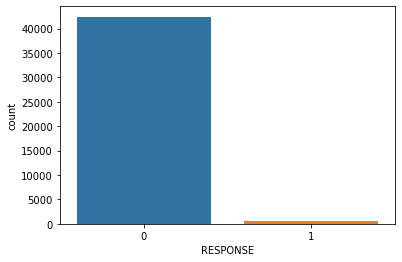

In [128]:
sns.countplot("RESPONSE",data=mailout_train)

Out of all the 42,962 individuals in the mailout campaign, only 1.24% of the individuals became customers. The dataset is highly imbalanced because of the disproportionate amount of customers and non-customers.

#### Knowing more about the Data

Before the imbalanced dataset can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, the features are similar to the general population dataset and the customers dataset.

In [129]:
# Check for missing value is 'RESPONSE' column
mailout_train['RESPONSE'].isnull().sum()

0

In [49]:
# # Selecting features and response in mailout_train dataset
# train_features = mailout_train.drop(['RESPONSE'], axis=1)
# train_response = mailout_train['RESPONSE']

In [68]:
# Identifying proportion of missing data in features in descenindg order
train_features_init_null = find_missing_vals(mailout_train)
train_features_init_null

,count_missing,percent
ALTER_KIND4,42921,99.90
ALTER_KIND3,42788,99.59
ALTER_KIND2,42206,98.24
ALTER_KIND1,40974,95.37
KK_KUNDENTYP,25316,58.93
...,...,...
RT_KEIN_ANREIZ,605,1.41
RETOURTYP_BK_S,605,1.41
CJT_KATALOGNUTZER,605,1.41
CJT_TYP_1,605,1.41


In [131]:
# # Identify missing or unknown data values in train_features dataframe columns 
# # nd convert them to NaNs as per nan_vals in feat_info
# for idx in unknowns_df.index:
#     column = idx
#     if column in mailout_train.columns:
#         mailout_train[column] = mailout_train[column].replace(unknowns_df.loc[column]['Value'], np.nan)

In [69]:
# Count value of NaN values in each column in descending order after encoding missing values
train_features_after_nan = find_missing_vals(mailout_train)
train_features_after_nan

,count_missing,percent
ALTER_KIND4,42921,99.90
ALTER_KIND3,42788,99.59
ALTER_KIND2,42206,98.24
ALTER_KIND1,40974,95.37
KK_KUNDENTYP,25316,58.93
...,...,...
RT_KEIN_ANREIZ,605,1.41
RETOURTYP_BK_S,605,1.41
CJT_KATALOGNUTZER,605,1.41
CJT_TYP_1,605,1.41


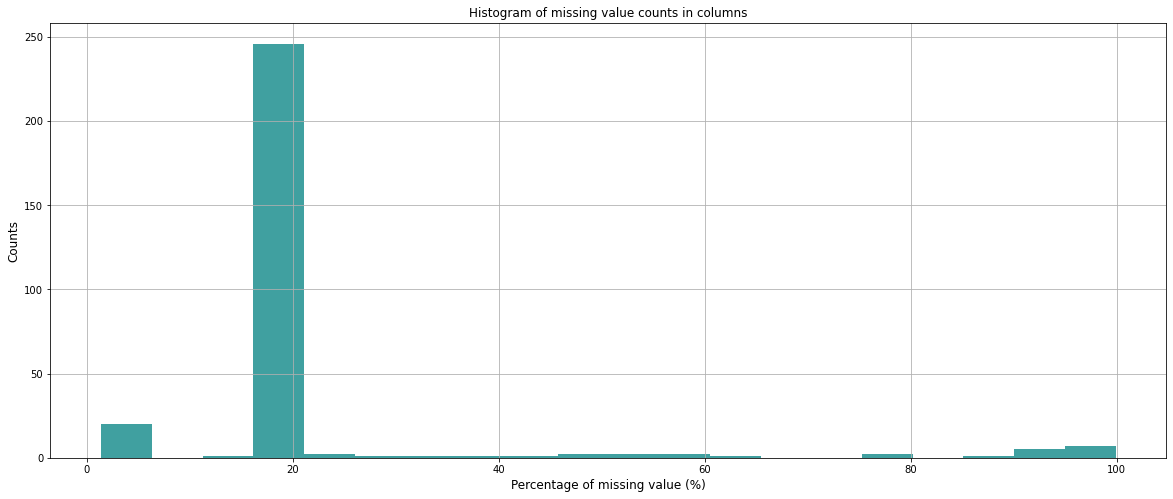

In [123]:
#Plot distribution of missing value counts in columns
plot_hist_missing_col(train_features_after_nan)

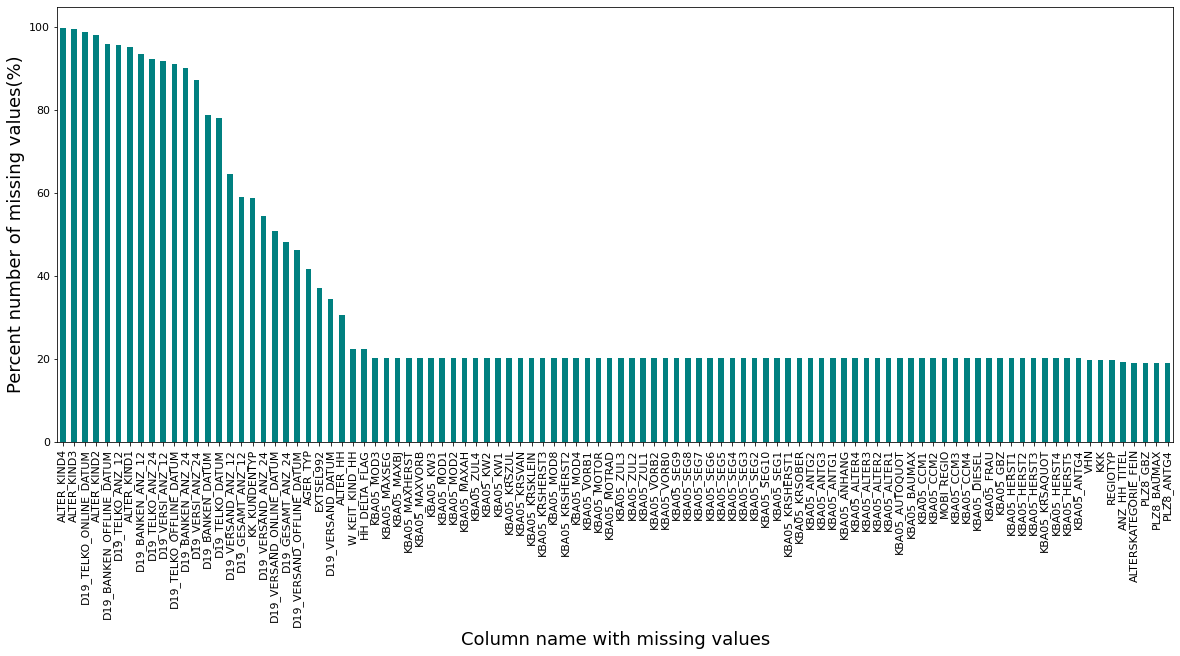

In [124]:
# Visualizing the top 50 features with missing data
plot_top100_feat(mailout_train)

In [11]:
# Find the name of columns with more than 25% missing values in train_features
missing_25 = find_cols_missing_pct_data(mailout_train, pct=25)
print(missing_25)


['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


In [12]:
# Number of features with more than 25% missing values
len(missing_25)

6

In [63]:
# How many features are there of each data type in train_features?
#find_feat_dtype(train_features)
print('Number of features of each data type are : {}'.format(find_feat_dtype(train_features)))

Number of features of each data type are : {dtype('int64'): 93, dtype('float64'): 267, dtype('O'): 6}


In [106]:
# Print columns with dtype as 'Object'
col_names_obj = []
for col in mailout_train.columns:
    if mailout_train[col].dtype.name == 'object':
        col_names_obj.append(col)
        
print(col_names_obj)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


#### Prepare the Data

##### Clean the data

Before the imbalanced dataset can be used as input for machine learning algorithms, it often must be cleaned. Fortunately, the features are similar to the general population dataset and the customers dataset.
In order to preserve all the rows to predict, clean_data function has been revised.

In [70]:
def clean_data_revised(df):
    
    print('Loading and Modifying the Feature Summary File... \n')
    # Load feature summary csv file
    # feature summary file is created manually mapping all the attributes with
    # the file has the azdias information namely: Attribute, Description, Meaning, and tYPE
    feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', 0, index_col=0)
    #Fill nulls by forward fill
    feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
    feat_info['Type'] = feat_info['Type'].fillna(method='ffill')
    #Drop duplicates
    feat_info = feat_info.drop_duplicates(subset = ['Attribute'])
    feat_info.set_index('Attribute', drop = True, inplace=True)
    
    
    print('Getting the list of Unknown Values from the Features Dataset... \n')
    #Definitions of unknowns in the various features
    list_unknown = ['unknown', 'unknown / no main age detectable', 
                'no transactions known', 'no transaction known']
    #Create a subset that has unknowns and their values
    unknowns_df = feat_info[feat_info['Meaning'].isin(list_unknown)]
    #Changing the value entry in feat info dataframe to get a list of unknown values in every column
    feat_info_dict = unknowns_df[['Value']].to_dict()['Value']
    new_dict = {}
    for key, value in feat_info_dict.items():
        new_dict.update({key:[str(value)]})
    unknowns_df['new_vals'] = unknowns_df.index.map(new_dict.get)
    unknowns_df['nan_vals'] = unknowns_df['new_vals'].astype(str).str.replace('[',''). \
                                                 str.replace(']','').str.replace("'",'').str.split(',').values
    #Converting (list of string) values to (list of integers and string) in nan_vals column.
    def is_int(value):
        try:
            int(value)

            return True
        except ValueError:

            return False
    unknowns_df['nan_vals'] = unknowns_df.apply(lambda x: [int(i) if is_int(i) else i for i in x['nan_vals']], 
                                                axis=1)
    
    print('Converting Unknowns to NaNs... \n')
    # Identify missing or unknown data values in train_features dataframe columns 
    # nd convert them to NaNs as per nan_vals in feat_info
    for idx in unknowns_df.index:
        column = idx
        if column in df.columns:
            df[column] = df[column].replace(unknowns_df.loc[column]['Value'], np.nan)

    
    print('Removing Columns with more than 25% missing values and LNR col... \n')
    # Find the name of columns with more than 25% missing values
    missing_25 = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 
                  'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 
                  'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 
                  'D19_BANKEN_OFFLINE_DATUM', 'D19_GESAMT_ANZ_12', 
                  'D19_GESAMT_ANZ_24', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 
                  'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 
                  'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 
                  'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 
                  'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 
                  'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 
                  'KK_KUNDENTYP']
    # Remove the outlier columns from the dataset
    df.drop(missing_25, axis=1, inplace=True)
    # Droping column LNR from azdias dataframe as column LNR is unique ID assigned to an each individual
    df.drop('LNR', axis=1, inplace=True)
    
    print('Creating Decade and Movement Columns')
    # Creating decade_dict and decade_list to be used in make_decade function.
    decade_dict = {1: [1, 2], 2: [3, 4], 3: [5, 6, 7], 
                   4: [8, 9], 5: [10, 11, 12, 13], 6:[14, 15]}
    #decade_dict.items()
    decade_dict.values()
    decade_list = []
    for dd in decade_dict.values():
        for i in dd:
            decade_list.append(i)
    
    def make_decade(x):
        if pd.isnull(x):
            return np.nan
        else:
            for key, array in decade_dict.items():
                if x in array:
                    return key
                elif x not in decade_list:
                    return np.nan
    
    def make_movement(x):
        if pd.isnull(x):
            return np.nan
        elif x in (2,4,6,7,9,11,13,15):
            return 0        
        elif x in (1,3,5,8,10,12,14):
            return 1
        else:
            return np.nan
    
    print('Re-encoding Various Categorical Variables')
    # select, re-encode, and engineer few features
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_decade)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['WOHNLAGE_rating_class'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1)
    
    # Taking care of 6 features with dtype as 'Object'
    df['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)
    
    #Make wealth and lifestage column
    def make_wealth(x):
        if (pd.isnull(x)) | (x == 'XX'):
            return np.nan 
        elif int(x) // 10 == 1:
            return 1
        elif int(x) // 10 == 2:
            return 2
        elif int(x) // 10 == 3:
            return 3
        elif int(x) // 10 == 4:
            return 4
        elif int(x) // 10 == 5:
            return 5
    
    def make_life_stage(x):
        if (pd.isnull(x)) | (x == 'XX'):
            return np.nan 
        elif int(x) % 10 == 1:
            return 1
        elif int(x) % 10 == 2:
            return 2
        elif int(x) % 10 == 3:
            return 3
        elif int(x) % 10 == 4:
            return 4
        elif int(x) % 10 == 5:
            return 5
        
    #Create wealth and life stage columns
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(make_wealth) 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(make_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    df = df.drop(['EINGEFUEGT_AM'], axis=1) # drop feature 'EINGEFUEGT_AM' as it contains unique timestamp
    
    #Create dummies
    multi = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE']
    df = pd.get_dummies(df, columns=multi, prefix=multi, dummy_na=True, drop_first=True)
    
    
    print('Filling the remaining nulls... \n')
    #Get the list of columns with null variables
    null_cols = df.columns[df.isna().any()].tolist()
    #Fill the remaining null variables:
    #all the above nulls, I will fill them with the mode
    for col in null_cols:
        df[col] = df[col].fillna(df[col].mode()[0])


    print('--------Done------')
    return df

In [71]:
# Prepare the data using the function clean_data_revised
mailout_cleaned = clean_data_revised(mailout_train)

Loading and Modifying the Feature Summary File... 

Getting the list of Unknown Values from the Features Dataset... 

Converting Unknowns to NaNs... 

Removing Columns with more than 25% missing values and LNR col... 

Creating Decade and Movement Columns
Re-encoding Various Categorical Variables
Filling the remaining nulls... 

--------Done------


In [136]:
# How many features are there of each data type in train_features?
#find_feat_dtype(train_features)
print('Number of features of each data type are : {}'.format(find_feat_dtype(mailout_cleaned)))

Number of features of each data type are : {dtype('float64'): 267, dtype('int64'): 70, dtype('uint8'): 80}


##### Feature Transformation

In [16]:
# Selecting features and response in mailout_train dataset
train_features = mailout_cleaned.drop(['RESPONSE'], axis=1)
train_response = mailout_cleaned['RESPONSE']

In [17]:
# Apply feature scaling to the train_features_imputed dataset.

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)


# Making train_features_scaled into a dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, 
                                     columns= list(train_features.columns.values))
train_features_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,K

In [18]:
train_features_scaled.shape

(42962, 416)

#### Evaluate Model Performance

Since there is a large output class imbalance, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the model will be using ROC-AUC to evaluate performance.


Aside from the Kaggle competition (see section below) using ROC-AUC as the score, the metric is suitable for binary classification problems such as this. ROC curves give us the ability to assess the performance of the classifier over its entire operating range. The most widely-used measure is the area under the curve (AUC). The AUC can be used to compare the performance of two or more classifiers. A single threshold can be selected and the classifiers’ performance at that point compared, or the overall performance can be compared by considering the AUC". Compared to the F1 score, the ROC does not require optimizing a threshold for each label.

##### Classification

In [19]:
# Define fit_classifier function to fit different classifiers on training dataset i.e. train_features_scaled
# to find the best performing classifier algorithm
def fit_classifier(clf, param_grid, X=train_features_scaled, y=train_response):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [22]:
# Initialize classification algorithms
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier

In [23]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [lor, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training LogisticRegression :
LogisticRegression
Time taken : 9.89 secs
Best score : 0.6522
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 53.79 secs
Best score : 0.603
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 53.49 secs
Best score : 0.7168
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 230.2 secs
Best score : 0.7565
****************************************


In [24]:
# Create clf_df dataframe from clf_dict
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

best_score  time_taken  \
LogisticRegression          0.652182    9.89         
RandomForestClassifier      0.602997    53.79        
AdaBoostClassifier          0.716805    53.49        
GradientBoostingClassifier  0.756471    230.20       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

So, from above, we can observe that the best performing classifier algorithm among the above 4 classifiers is GradientBoostingClassifier.

In [25]:
# Print the best estimator of GradientBoostingClassifier
clf_df.loc['GradientBoostingClassifier', 'best_est']

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
# Print the classes known to the best estimator of GradientBoostingClassifier
clf_df.loc['GradientBoostingClassifier', 'best_est'].classes_

array([0, 1])

##### Tuning the model

In [33]:
# Tune the best classifier(GradientBoostingClassifier) with the help of param grid in GridSearchCV
# The fine tuned model will be used with the test set
param_grid = {
              'loss': ['exponential'],
              'learning_rate': [0.01],
              'n_estimators': [100],
              'max_depth': [8],
              'min_samples_split': [3]
             } #0.762

gbc = GradientBoostingClassifier(random_state=42)
gbc_best_score, gbc_best_est, _ = fit_classifier(gbc, param_grid)
gbc_best_est

Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 766.54 secs
Best score : 0.7621
****************************************


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='exponential', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
# pickle file and save the model to disk.
filename = 'best_classifier.pkl'
outfile = open(filename, 'wb')
model = gbc_best_est
pickle.dump(model, outfile)
outfile.close()

##### Print Most Important Features

In [37]:
# Print the most important features of the model
imp_feat = pd.DataFrame({'imp_feat':gbc_best_est.feature_importances_}, index=train_features_scaled.columns)
imp_feat_sorted = imp_feat.sort_values(by=['imp_feat'], ascending=False)
imp_feat_sorted.head(10)

,imp_feat
D19_SOZIALES,0.065964
KBA13_ANZAHL_PKW,0.025391
ANZ_STATISTISCHE_HAUSHALTE,0.025015
SEMIO_REL,0.016312
ANZ_HAUSHALTE_AKTIV,0.015957
ANZ_KINDER,0.014961
KBA05_ZUL3,0.014936
D19_LETZTER_KAUF_BRANCHE_nan,0.013891
D19_KONSUMTYP_MAX,0.013780
CAMEO_DEU_2015_6E,0.013662


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [38]:
#Load the test dataset
mailout_test = pd.read_pickle('mailout_test.pkl')
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

#### Explore the Data

In [39]:
# Print shape of test dataset
mailout_test.shape

(42833, 366)

In [40]:
# Extract feature 'LNR' to be used later for generation of the Kaggle competition CSV file with two columns
# The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition
# The second column, "RESPONSE", should be some measure of how likely each individual became a customer –
# this might not be a straightforward probability.
test_LNR = mailout_test['LNR']

# Print shape of test_LNR
test_LNR.shape

(42833,)

#### Prepare the Dataset

##### clean the data

In [42]:
# Prepare the test data using the function clean_data_revised
test_cleaned = clean_data_revised(mailout_test)

Loading and Modifying the Feature Summary File... 

Getting the list of Unknown Values from the Features Dataset... 

Converting Unknowns to NaNs... 

Removing Columns with more than 25% missing values and LNR col... 

Creating Decade and Movement Columns
Re-encoding Various Categorical Variables
Filling the remaining nulls... 

--------Done------


In [43]:
# Print shape of test dataset after cleaning
test_cleaned.shape

(42833, 416)

##### Feature Transformation

In [44]:
# Apply feature scaling to the test_imputed dataset using the scaler fitted earlier on the train data
test_scaled = pd.DataFrame(scaler.transform(test_cleaned), columns= list(test_cleaned.columns.values))
# Print shape of test_scaled
print('Shape of test_scaled is: {}'.format(test_scaled.shape))

Shape of test_scaled is: (42833, 416)


#### Classification of test data using best model trained on train data

##### Predicting using the best model

In [46]:
#Predict the classification of the test data using best model trained earlier on train data in Part 2 
test_response = gbc_best_est.predict(test_scaled)

In [47]:
# Print shape of test_response
test_response.shape

(42833,)

In [48]:
# Predict the class probabilities of the test data using best model trained earlier on train data in Part 2 
test_response_proba = gbc_best_est.predict_proba(test_scaled)
test_response_proba

array([[0.978138  , 0.021862  ],
       [0.97897132, 0.02102868],
       [0.99686576, 0.00313424],
       ...,
       [0.98124756, 0.01875244],
       [0.97558506, 0.02441494],
       [0.9851592 , 0.0148408 ]])

In [49]:
#Print the classes
gbc_best_est.classes_

array([0, 1])

#### Output for Kaggle Competition

In [50]:
# Create dataframe kaggle_df with two columns
# The first column is a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition
# The second column, "RESPONSE", is a measure of how likely each individual became a customer –
# this might not be a straightforward probability.
kaggle_df = pd.DataFrame({'LNR': test_LNR, 'RESPONSE': test_response_proba[:, 1]})
kaggle_df.head()

,LNR,RESPONSE
0,1754,0.021862
1,1770,0.021029
2,1465,0.003134
3,1470,0.003245
4,1478,0.012068


In [51]:
# Generate CSV file for the Kaggle competition
kaggle_df.to_csv('kaggle_submission.csv', index=False)